# Flight Data Analysis
## by Luke DeMaster-Smith

<a id='top_of_page'></a>
## Table of Contents

- **[Preliminary Wrangling](#preliminary_wrangling)**
  - [Load and Preview Data](#preliminary_wrangling_load_flight_data)
  - [Structure of Dataset](#preliminary_wrangling_structure)
  - [Main Features](#preliminary_wrangling_main_features)
  - [Features to Focus On](#preliminary_wrangling_features_to_focus_on)

- **[Univariate Exploration](#univariate_exploration)**
  - [Delay Variables - Initial Observations](#univariate_delay_initial_observations)
  - [Delay Variables - Additional Observations](#univariate_delay_additional_observations)
  - [Other Variables - Observations](#univariate_otherVar_observations)
  - [Summary](#univariate_exploration_summary)
    - [Distributions of Interest](#univariate_exploration_describe_distributions_of_interest)
    - [Unusual distributions and Modifications](#univariate_exploration_unusual_distributions_and_modifications)

- **[Bivariate Exploration](#bivariate_exploration)**
  - [Correlation Heat Maps](#bivariate_exploration_heatMaps)
  - [Violin Plots](#bivariate_exploration_violinPlots) 
  - [Box Plots](#bivariate_exploration_boxPlots)
  - [2D Histograms](#bivariate_exploration_2D_Histograms)
  - [Summary](#bivariate_exploration_summary)
    - [Relationships Observed](#bivariate_exploration_relationships_observed)
    - [Unexpected Relationships](#bivariate_exploration_relationships_observed_unexpected)

- **[Multivariate Exploration](#multivariate_exploration)**
  - [Colored Scatter Plots](#multivariate_scatter)
  - [Calendar Plots](#multivariate_calendar)
    - [Setup](#multivariate_calendar_setup)
    - [Delays by Airport](#multivariate_calendar_delays_by_airport)
    - [Delays by Airline](#multivariate_calendar_delays_by_airline)
  - [Summary](#multivariate_exploration_summary)
    - [Relationships Observed](#multivariate_exploration_relationships_observed)
    - [Interesting Interactions](#multivariate_exploration_relationships_observed_interesting_interactions)

- **[References](#references)**

<a id='preliminary_wrangling'></a>
([Top of Page](#top_of_page))
## Preliminary Wrangling

* In this investigation, I chose a dataset of U.S. flight data that was [provided by the American Statistical Association](http://stat-computing.org/dataexpo/2009/the-data.html) and originally came from the U.S. Bureau of Transportation Statistics.
* My goal is to assess which features best predict (or correlate to) the length of flight delays.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time           # for timing operations on large dataframes

import random
random.seed(42)

%matplotlib inline

<a id='preliminary_wrangling_load_flight_data'></a>
([Top of Page](#top_of_page))

**Load and Preview Data**

In [2]:
# load a single year's dataset into a pandas dataframe
start = time.time()
flights = pd.read_csv('2008.csv')           #flights_2008
end = time.time()

currTime = str(time.localtime().tm_hour) + ':' + str(time.localtime().tm_min) + ':' + str(time.localtime().tm_sec)
print('time elapsed: ' + str(end - start) + ', current time: ' + currTime)

time elapsed: 35.51989984512329, current time: 21:17:4


In [3]:
# high-level overview of data shape and composition
print(flights.shape)
print(flights.dtypes)

(7009728, 29)
Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object


**Initial Observations:**
* There are over 7 million rows, and it took over 30 seconds to load the csv.
* In order to speed up analysis and plotting, I am going to do the following:
  * Only analyze one year's worth of flight data.
    * Obviously, it would be interesting to assess changes over the course of multiple years.
    * However, I suspect there is enough data within a single year to provide some insights.
    * More importantly though, I'm not sure my computer can handle multiple years worth of data very well
  * Sample the data. I suspect a moderately large sample size (say..100000) will be sufficient.
    * If analysis indicates that it would be beneficial to look at the entire year's worth of data, I will do so
* If analysis leads me to a key metric or plot that would clearly benefit from a larger data set, I will adjust my analysis accordingly.

In [4]:
# Backup the data
flights_orig = flights.copy(deep=True)   # version to leave unaltered
flights_all = flights.copy(deep=True)    # version to modify / use as necessary

In [5]:
# sample 100000 flights, then display head to get a better sense of the data
samples = np.random.choice(flights_all.shape[0], 100000, replace = False)
flights = flights_all.loc[samples,:]
flights.head(10)

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
3807127  2008      7          18          5   1611.0        1615   1821.0   
5534469  2008     10          23          4   1840.0        1840   2040.0   
7197     2008      1           5          6   1059.0        1055   1243.0   
2018518  2008      4          23          3   1935.0        1941   2038.0   
6833116  2008     12           1          1   1820.0        1525   1927.0   
3318970  2008      6          25          3    854.0         904   1121.0   
3586764  2008      6           5          4   2135.0        2030   2230.0   
2238345  2008      4           2          3   1105.0        1110   1625.0   
2113090  2008      4          23          3   1330.0        1330   1350.0   
3902116  2008      7          24          4   1645.0        1615   1849.0   

         CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
3807127        1830            OO       2774  ...    5.0     10.0          0   
5534469        2029            OH       6675  ...   10.0     51.0          0   
7197           1245            WN        417  ...    5.0     11.0          0   
2018518        2040            UA        461  ...   14.0     15.0          0   
6833116        1640            MQ       3944  ...    8.0     17.0          0   
3318970        1129            EV       4288  ...    9.0     14.0          0   
3586764        2138            DL       1935  ...    2.0     13.0          0   
2238345        1554            OH       5202  ...   40.0     22.0          0   
2113090        1400            EV       4373  ...    5.0     17.0          0   
3902116        1743            US       1262  ...    5.0     45.0          0   

         CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
3807127               NaN         0           NaN          NaN      NaN   
5534469               NaN         0           NaN          NaN      NaN   
7197                  NaN         0           NaN          NaN      NaN   
2018518               NaN         0           NaN          NaN      NaN   
6833116               NaN         0           0.0          0.0      0.0   
3318970               NaN         0           NaN          NaN      NaN   
3586764               NaN         0          52.0          0.0      0.0   
2238345               NaN         0           0.0          0.0     31.0   
2113090               NaN         0           NaN          NaN      NaN   
3902116               NaN         0           0.0          0.0     66.0   

         SecurityDelay  LateAircraftDelay  
3807127            NaN                NaN  
5534469            NaN                NaN  
7197               NaN                NaN  
2018518            NaN                NaN  
6833116            0.0              167.0  
3318970            NaN                NaN  
3586764            0.0                0.0  
2238345            0.0                0.0  
2113090            NaN                NaN  
3902116            0.0                0.0  

[10 rows x 29 columns]

**Determine which columns are not shown above, then visualize them**

In [6]:
flights.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [7]:
cols_to_show = ['TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'ActualElapsedTime',
                'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance']

In [8]:
flights[cols_to_show].head(10)

TailNum  ActualElapsedTime  CRSElapsedTime  AirTime  ArrDelay  \
3807127  N507CA               70.0            75.0     55.0      -9.0   
5534469  N958CA              120.0           109.0     59.0      11.0   
7197     N261WN              164.0           170.0    148.0      -2.0   
2018518  N654UA              123.0           119.0     94.0      -2.0   
6833116  N614MQ               67.0            75.0     42.0     167.0   
3318970  N643AS               87.0            85.0     64.0      -8.0   
3586764  N908DE               55.0            68.0     40.0      52.0   
2238345  N676CA              260.0           224.0    198.0      31.0   
2113090  N843AS               80.0            90.0     58.0     -10.0   
3902116  N738US              124.0            88.0     74.0      66.0   

         ActualElapsedTime  CRSElapsedTime  AirTime  ArrDelay  DepDelay  \
3807127               70.0            75.0     55.0      -9.0      -4.0   
5534469              120.0           109.0     59.0      11.0       0.0   
7197                 164.0           170.0    148.0      -2.0       4.0   
2018518              123.0           119.0     94.0      -2.0      -6.0   
6833116               67.0            75.0     42.0     167.0     175.0   
3318970               87.0            85.0     64.0      -8.0     -10.0   
3586764               55.0            68.0     40.0      52.0      65.0   
2238345              260.0           224.0    198.0      31.0      -5.0   
2113090               80.0            90.0     58.0     -10.0       0.0   
3902116              124.0            88.0     74.0      66.0      30.0   

        Origin Dest  Distance  
3807127    MKE  CLE       328  
5534469    JFK  DCA       213  
7197       MCO  MDW       989  
2018518    IAD  ORD       589  
6833116    JFK  BWI       184  
3318970    VPS  ATL       264  
3586764    BOS  LGA       185  
2238345    AUS  JFK      1522  
2113090    CVG  MEM       403  
3902116    PHL  BOS       280

In [9]:
flights.describe()

Year          Month     DayofMonth      DayOfWeek       DepTime  \
count  100000.0  100000.000000  100000.000000  100000.000000  98108.000000   
mean     2008.0       6.363750      15.725790       3.925800   1334.010162   
std         0.0       3.415159       8.813071       1.987203    479.766625   
min      2008.0       1.000000       1.000000       1.000000      1.000000   
25%      2008.0       3.000000       8.000000       2.000000    927.000000   
50%      2008.0       6.000000      16.000000       4.000000   1325.000000   
75%      2008.0       9.000000      23.000000       6.000000   1730.000000   
max      2008.0      12.000000      31.000000       7.000000   2400.000000   

          CRSDepTime       ArrTime     CRSArrTime      FlightNum  \
count  100000.000000  97881.000000  100000.000000  100000.000000   
mean     1326.410160   1480.909461    1494.977340    2214.141240   
std       466.038488    506.638044     484.203103    1955.000764   
min         1.000000      1.000000       1.000000       1.000000   
25%       925.000000   1106.000000    1114.000000     620.000000   
50%      1320.000000   1511.000000    1515.500000    1566.000000   
75%      1719.000000   1909.000000    1909.000000    3485.000000   
max      2359.000000   2400.000000    2400.000000    9740.000000   

       ActualElapsedTime  ...       Distance        TaxiIn       TaxiOut  \
count       97845.000000  ...  100000.000000  97881.000000  98096.000000   
mean          127.006653  ...     723.665760      6.844924     16.426674   
std            69.997552  ...     560.278059      4.867985     11.336088   
min            16.000000  ...      31.000000      0.000000      0.000000   
25%            76.000000  ...     325.000000      4.000000     10.000000   
50%           109.000000  ...     579.000000      6.000000     14.000000   
75%           157.000000  ...     950.000000      8.000000     19.000000   
max           750.000000  ...    4962.000000    159.000000    338.000000   

           Cancelled       Diverted  CarrierDelay  WeatherDelay      NASDelay  \
count  100000.000000  100000.000000  21630.000000  21630.000000  21630.000000   
mean        0.019090       0.002460     15.827462      3.108460     17.020851   
std         0.136842       0.049538     40.645803     20.680145     32.364810   
min         0.000000       0.000000      0.000000      0.000000      0.000000   
25%         0.000000       0.000000      0.000000      0.000000      0.000000   
50%         0.000000       0.000000      0.000000      0.000000      6.000000   
75%         0.000000       0.000000     16.000000      0.000000     21.000000   
max         1.000000       1.000000   1160.000000    951.000000   1137.000000   

       SecurityDelay  LateAircraftDelay  
count   21630.000000       21630.000000  
mean        0.086177          20.353860  
std         1.990539          38.689385  
min         0.000000           0.000000  
25%         0.000000           0.000000  
50%         0.000000           0.000000  
75%         0.000000          26.000000  
max       169.000000         784.000000  

[8 rows x 24 columns]

In [10]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 3807127 to 4377816
Data columns (total 29 columns):
Year                 100000 non-null int64
Month                100000 non-null int64
DayofMonth           100000 non-null int64
DayOfWeek            100000 non-null int64
DepTime              98108 non-null float64
CRSDepTime           100000 non-null int64
ArrTime              97881 non-null float64
CRSArrTime           100000 non-null int64
UniqueCarrier        100000 non-null object
FlightNum            100000 non-null int64
TailNum              98844 non-null object
ActualElapsedTime    97845 non-null float64
CRSElapsedTime       99989 non-null float64
AirTime              97845 non-null float64
ArrDelay             97845 non-null float64
DepDelay             98108 non-null float64
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
TaxiIn               97881 non-null float64
TaxiOut    

<a id='preliminary_wrangling_structure'></a>
([Top of Page](#top_of_page))
### What is the structure of your dataset?

* There are over 7 million rows in the dataset. That is a lot of data. In order to have a dataset that is large enough to analyze some trends, but small enough to allow quick analysis and plotting, I decided to:
  * only analyze year (2008)
  * sample 100000 flights from that year
* Most variables are numeric with type float.
* There appear to be NAN entries for some features. These rows may need to be dropped or filtered out when analyzing data.
* The date is spread out over three variables. Adding a new variable, simply called 'Date', would be useful.
* Adding another feature called 'DayOfYear' may also be useful.

<a id='preliminary_wrangling_main_features'></a>
([Top of Page](#top_of_page))
### What is/are the main feature(s) of interest in your dataset?

* I am mostly interested in delays and determining which features best predict (or correlate to) the amount of delay.

<a id='preliminary_wrangling_features_to_focus_on'></a>
([Top of Page](#top_of_page))
### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

* Some of the main features include delay types, the timing of various events (departure, arrival, taxiing, elapsed time, etc.), the date, and the airports.
* I suspect that departure date and/or time will have a noticeable affect on the arrrival delay.
* I also suspect that delays will be longer on the weekends than on weekdays.

<a id='univariate_exploration'></a>
([Top of Page](#top_of_page))
## Univariate Exploration

**Define a function to plot multiple standard scale histograms**

In [11]:
def plot_histograms_stdAxis(flights, var, xaxis_label, numPlots, min_vals, max_vals, binsizes):
    fig, ax = plt.subplots(nrows=numPlots, figsize = [8, numPlots * 3.5])
    for i in range(numPlots):
        bin_edges = np.arange(min_vals[i], max_vals[i]+binsizes[i], binsizes[i])
        ax[i].hist(data = flights, x = var, bins = bin_edges);
        ax[i].set_title(flights[var].name + '\n' +
                        'min: ' + str(min_vals[i]) +
                        ', max: ' + str(max_vals[i]) +
                        ', binsize: ' +
                        str(binsizes[i]) + ' ',
                        pad=-30, loc='right')

    plt.xlabel(xaxis_label)
    plt.show()

In [12]:
flights.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

**Create standard scale histograms of the various 'Delay' parameters**

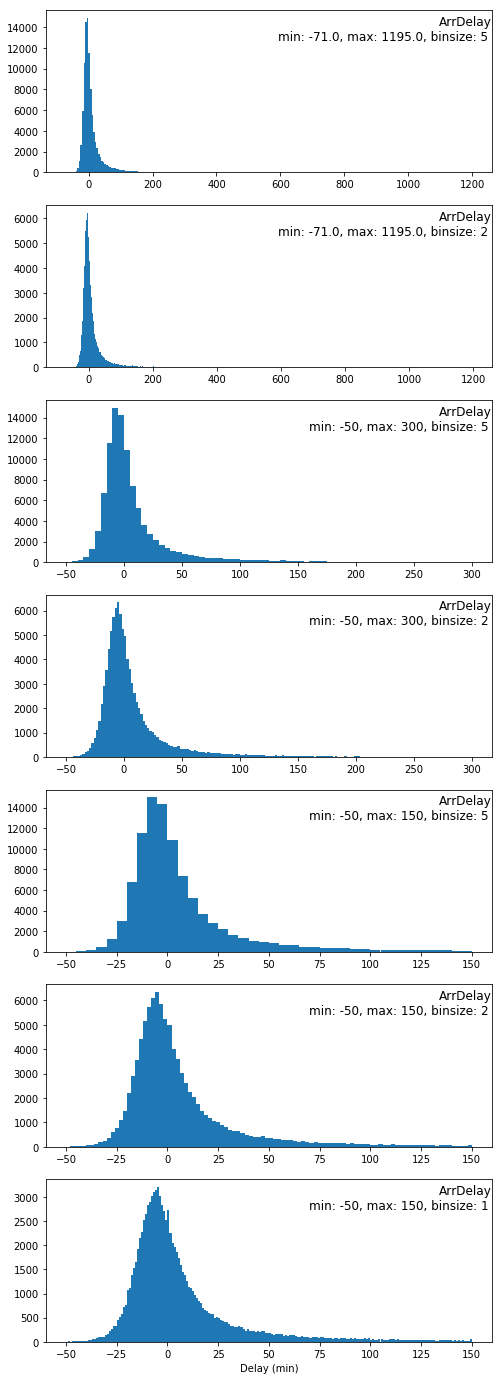

------------------------------------------------------------------------------------


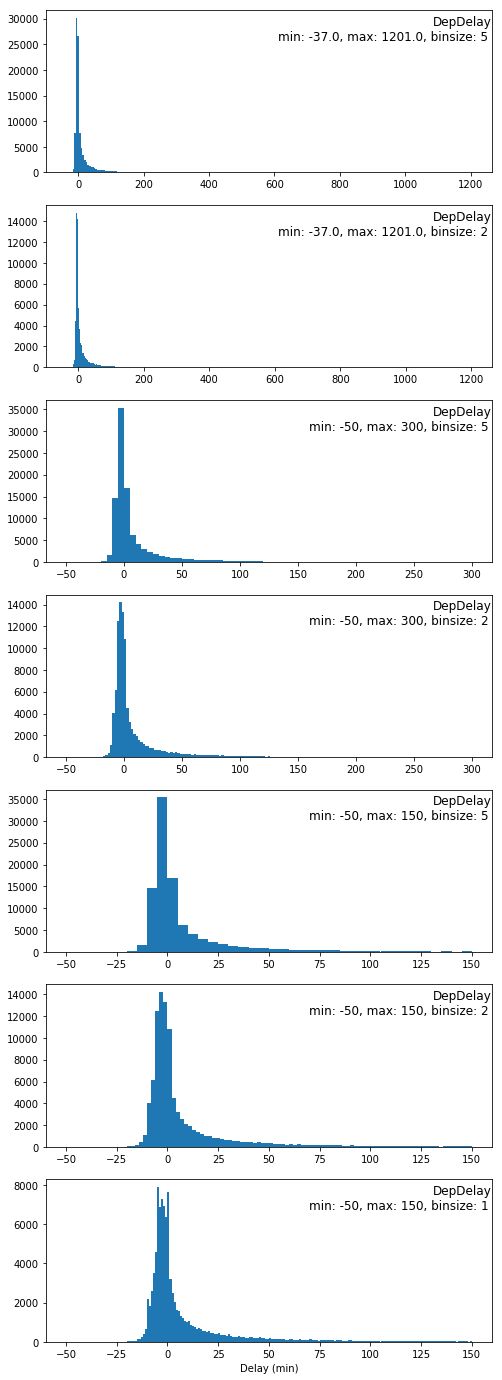

------------------------------------------------------------------------------------


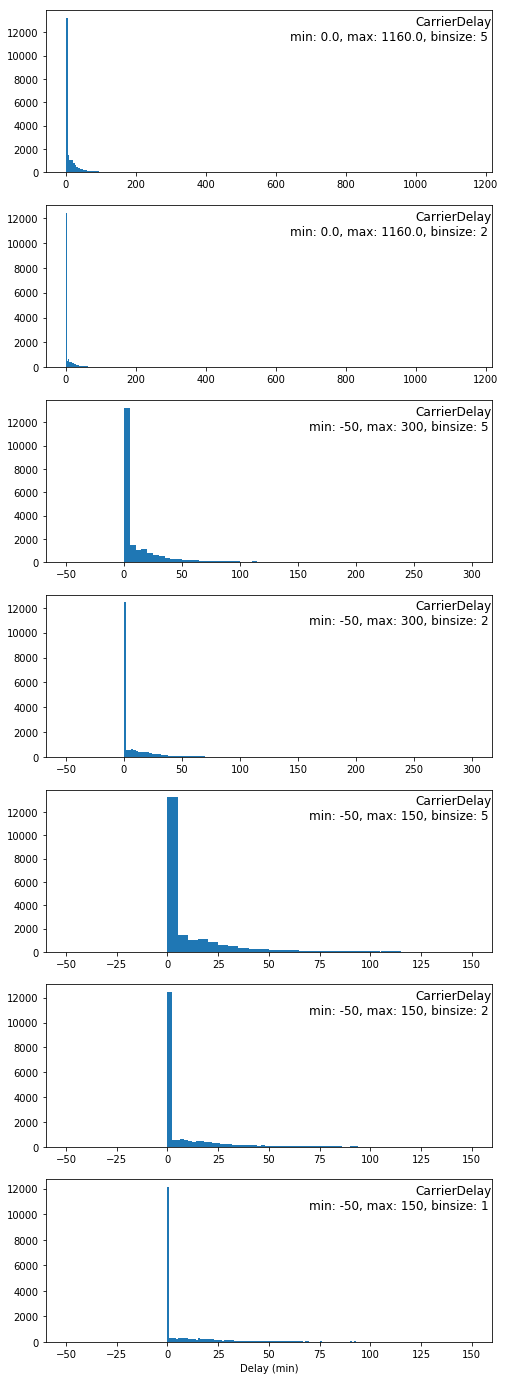

------------------------------------------------------------------------------------


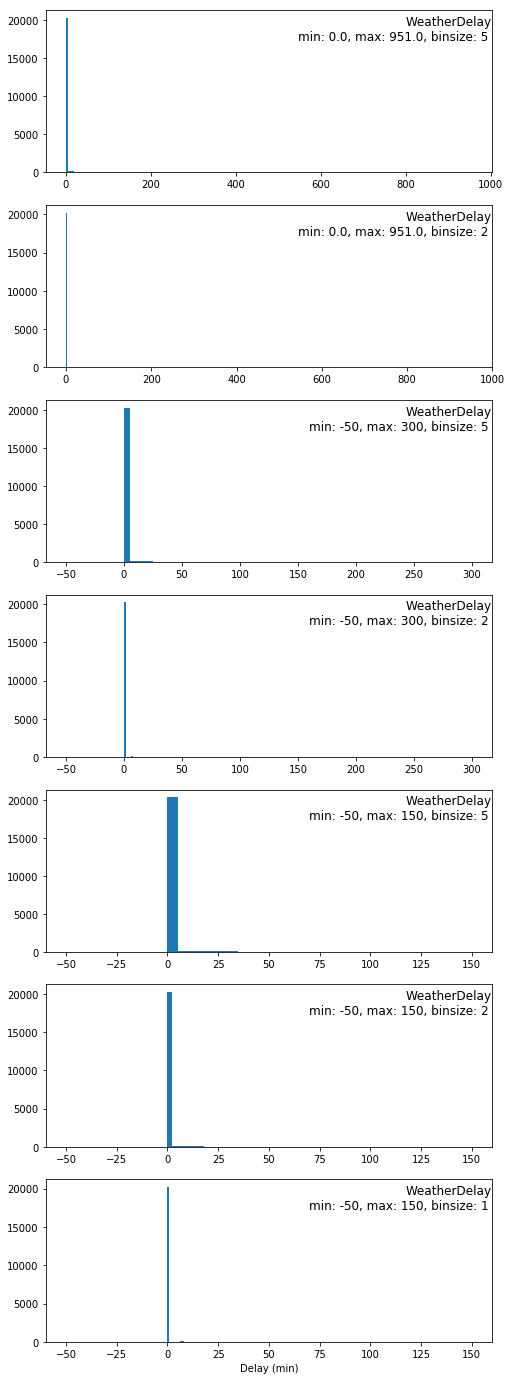

------------------------------------------------------------------------------------


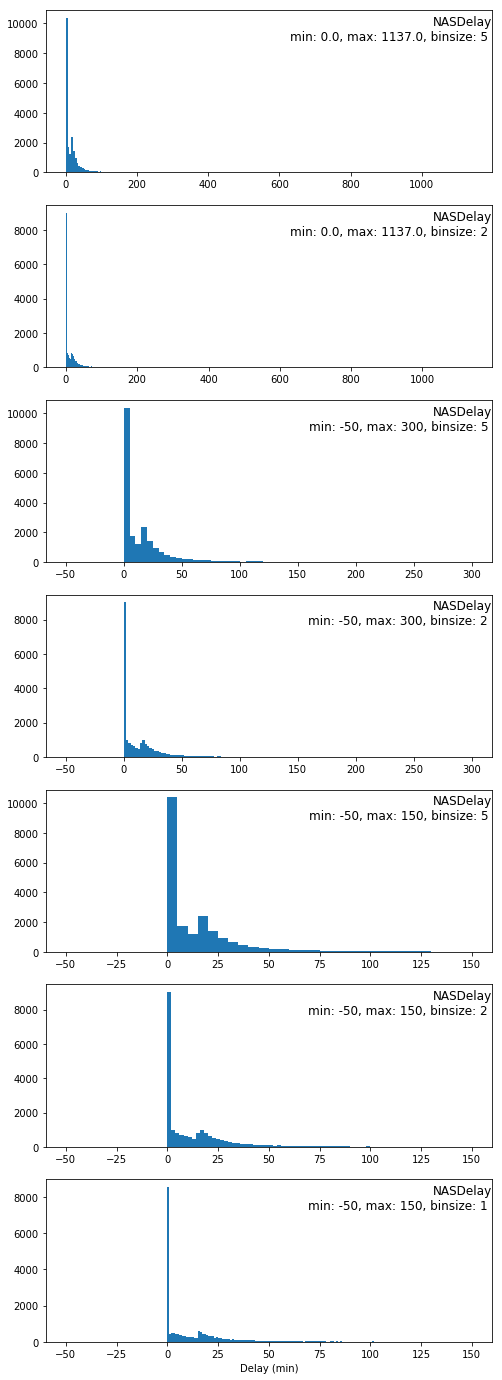

------------------------------------------------------------------------------------


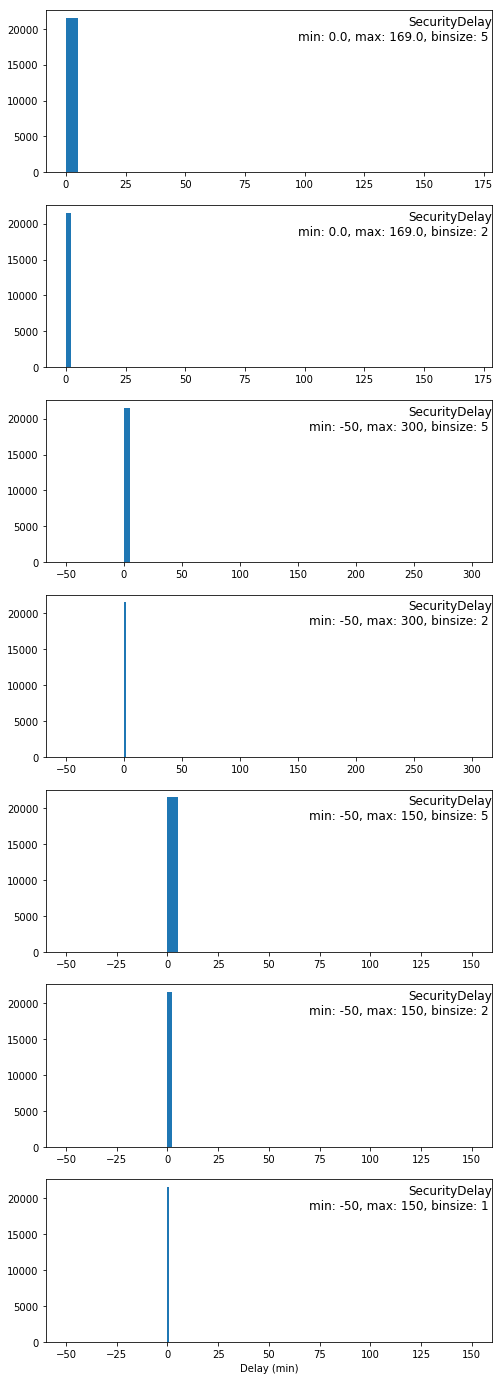

------------------------------------------------------------------------------------


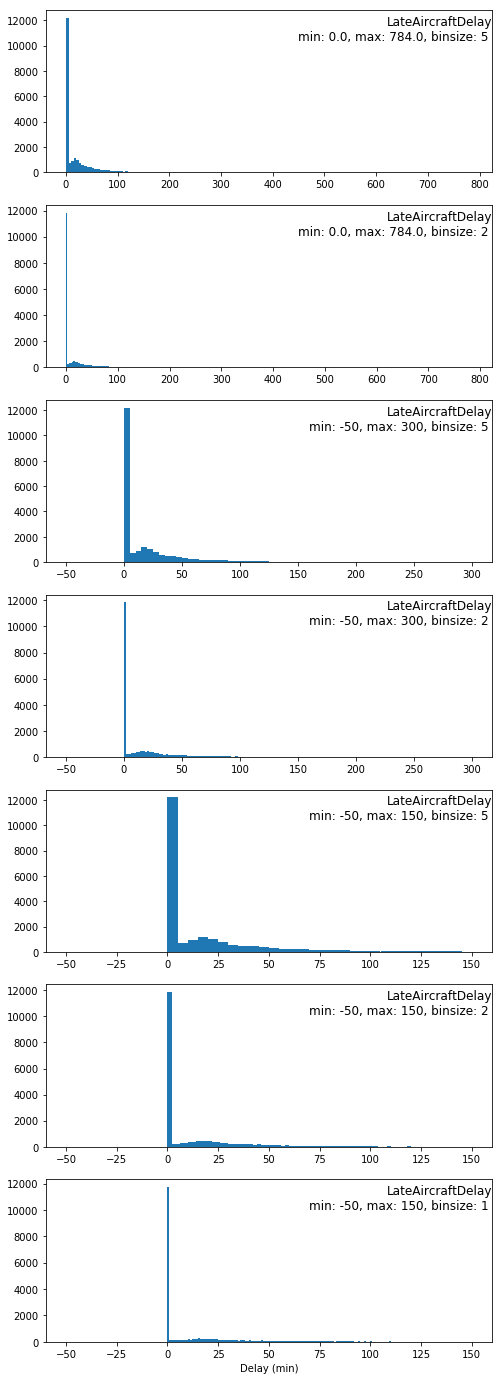

------------------------------------------------------------------------------------


In [13]:
vars = ['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
numPlots = 7;
for i in range(len(vars)):
    var = vars[i]
    min_values = [flights[var].min(), flights[var].min(),
                  -50, -50, -50, -50, -50]
    max_values = [flights[var].max(), flights[var].max(),
                  300, 300, 150, 150, 150]
    binsizes = [5, 2, 5, 2, 5, 2, 1]
    plot_histograms_stdAxis(flights, var, 'Delay (min)', numPlots, min_values, max_values, binsizes)
    print('------------------------------------------------------------------------------------')

**Zoom in on the 'ArrDelay' histogram to get a better sense of its distribution**

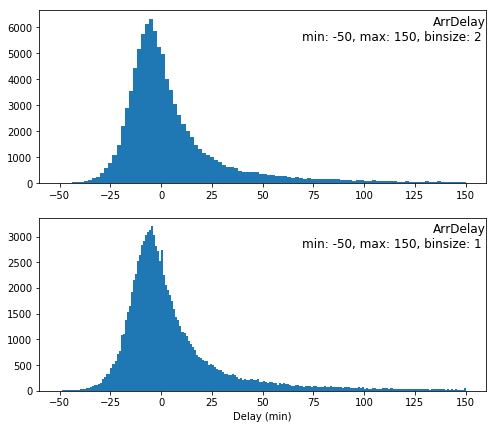

In [14]:
vars = ['ArrDelay']
numPlots = 2;
for i in range(len(vars)):
    var = vars[i]
    min_values = [-50, -50]
    max_values = [150, 150]
    binsizes = [2, 1]
    plot_histograms_stdAxis(flights, var, 'Delay (min)', numPlots, min_values, max_values, binsizes)

**Repeat for 'DepDelay'**

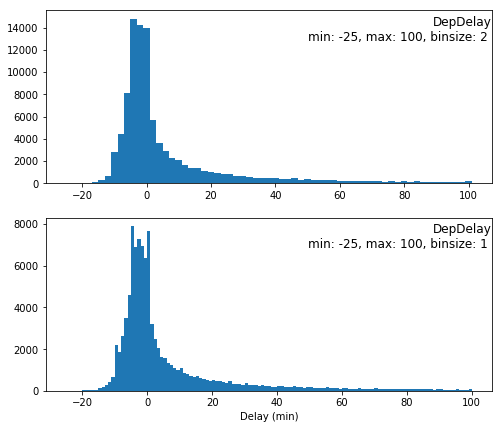

In [15]:
vars = ['DepDelay']
numPlots = 2;
for i in range(len(vars)):
    var = vars[i]
    min_values = [-25, -25]
    max_values = [100, 100]
    binsizes = [2, 1]
    plot_histograms_stdAxis(flights, var, 'Delay (min)', numPlots, min_values, max_values, binsizes)

<a id='univariate_delay_initial_observations'></a>
([Top of Page](#top_of_page))<br>

**'Delay' Variables - Initial Observations**

* **'ArrDelay'** and **'DepDelay'**:
  * Have roughly normal distributions around zero, albeit with some outliers causing a right-handed skew.
  * May need plotted on a log-scale for some plots due to their long tails
* **'CarrierDelay', 'WeatherDelay', 'NASDelay',** and **'LateAircraftDelay'** each have a large number of points at or very near zero. This is disguising the true nature of these distributions.
  * These distributions will have to be explored in greater detail
* **'NASDelay'** seems to have bi-modal distribution, which was not expected.
  * This may warrant further exploration.
* **'SecurityDelay'** seems to be almost uniformly zero.
  * It turns out this parameter is not _uniformly_ zero, but since it is _mostly_ zeros, this parameter is not a large driver of delays and will be ignored
* **'LateAircraftDelay'** seems to have a spike in frequency around 20 minutes

**Define a function to plot multiple log scale histograms**

In [16]:
def plot_histograms_logAxis(flights, var, xaxis_label, numPlots, max_vals, log_binsizes, ticks):
    fig, ax = plt.subplots(nrows=numPlots, figsize = [8, numPlots * 3.5])
    labels = ['{}'.format(v) for v in ticks]
    for i in range(numPlots):
        #bin_edges = np.arange(min_vals[i], max_vals[i]+binsizes[i], binsizes[i])        
        #bin_edges =       np.arange(min_vals[i],            max_vals[i]+binsizes[i], binsizes[i])
        bin_edges = 10 ** np.arange(0, np.log10(max_vals[i])+log_binsizes[i], log_binsizes[i])
        ax[i].hist(data = flights, x = var, bins = bin_edges);
        ax[i].set_xscale('log')
        ax[i].xaxis.set_ticks(ticks)
        ax[i].xaxis.set_ticklabels(labels)
        ax[i].set_title(flights[var].name + '\n' +
                        'max: ' + str(max_vals[i]) +
                        ', log_binsize: ' +
                        str(log_binsizes[i]) + ' ',
                        pad=-30, loc='right')

    plt.xlabel(xaxis_label)
    plt.show()

**Create log-scale histograms of the 'Delay' variables that have a large number of points near zero**

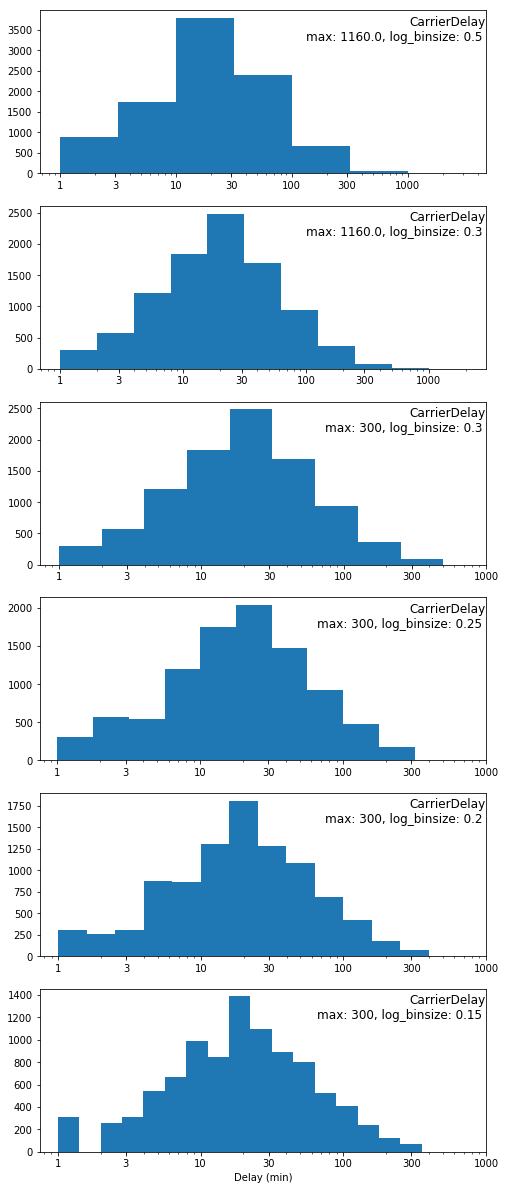

------------------------------------------------------------------------------------


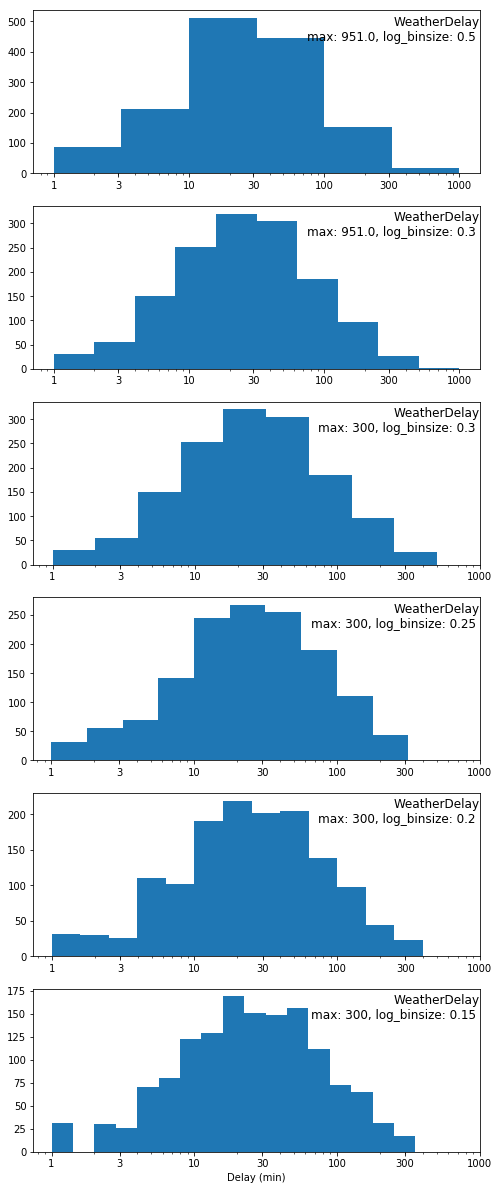

------------------------------------------------------------------------------------


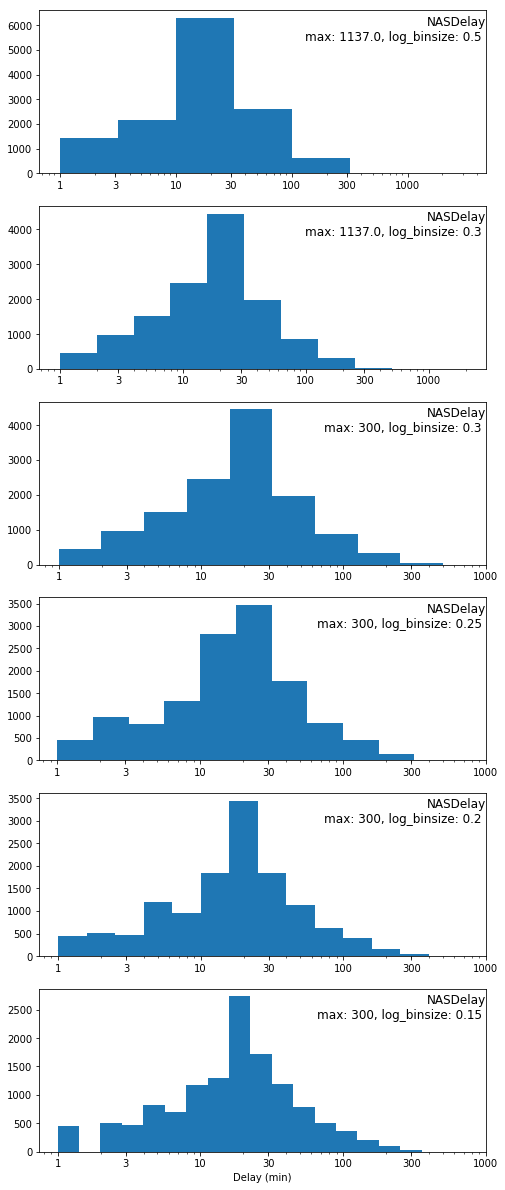

------------------------------------------------------------------------------------


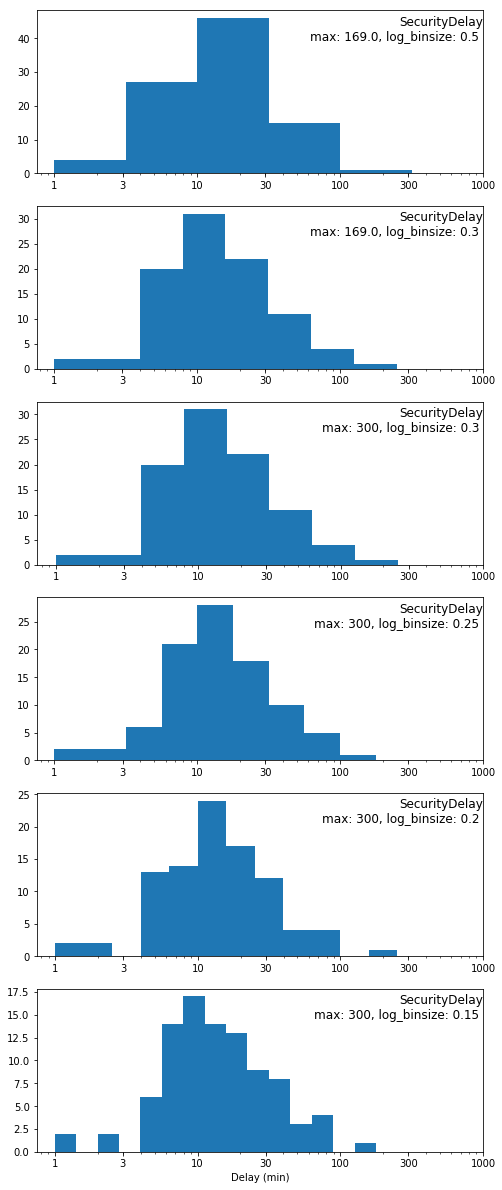

------------------------------------------------------------------------------------


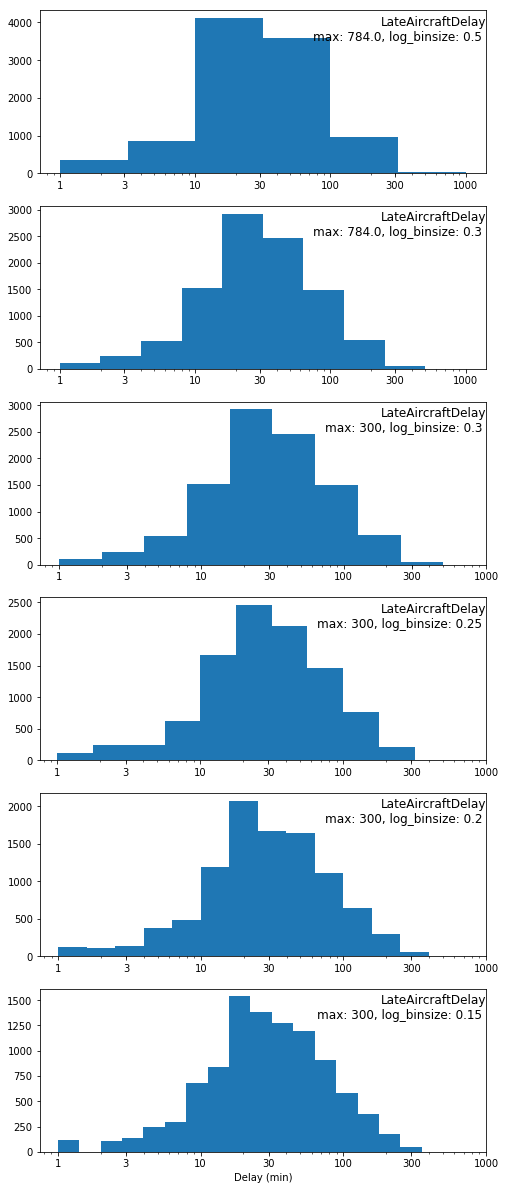

------------------------------------------------------------------------------------


In [17]:
vars = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
numPlots = 6;
for i in range(len(vars)):
    var = vars[i]
    max_values = [flights[var].max(),
                  flights[var].max(),
                  300, 300, 300, 300]
    log_binsizes = [0.5, 0.3, 0.3, 0.25, 0.2, 0.15]
    ticks = [1, 3, 10, 30, 100, 300, 1000]
    plot_histograms_logAxis(flights, var, 'Delay (min)', numPlots, max_values, log_binsizes, ticks)
    print('------------------------------------------------------------------------------------')

**Create standard scale histograms of the variables that have a large number of points near zero**
* Start these histograms at a value larger than zero

**'CarrierDelay' distribution**

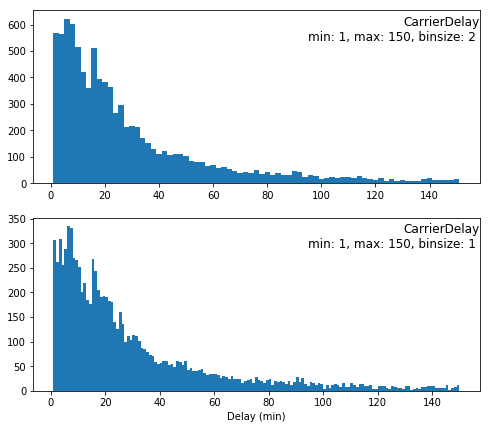

In [18]:
vars = ['CarrierDelay']
numPlots = 2;
for i in range(len(vars)):
    var = vars[i]
    min_values = [1, 1]
    max_values = [150, 150]
    binsizes = [2, 1]
    plot_histograms_stdAxis(flights, var, 'Delay (min)', numPlots, min_values, max_values, binsizes)

**'WeatherDelay' distribution**

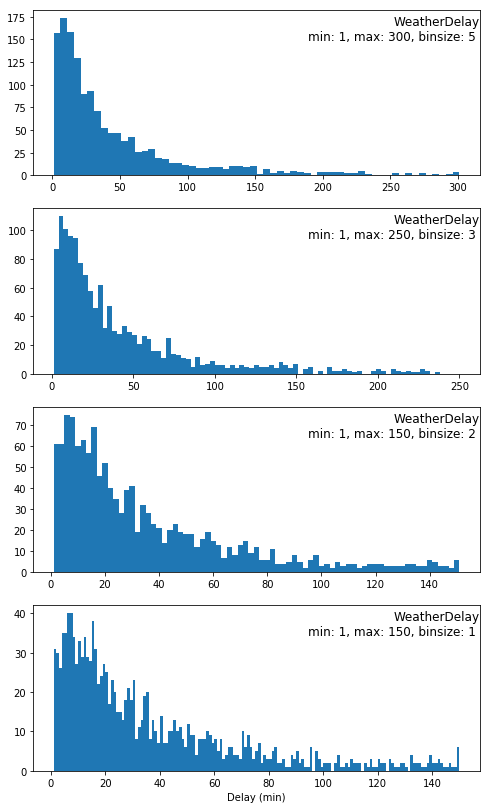

In [19]:
vars = ['WeatherDelay']
numPlots = 4;
for i in range(len(vars)):
    var = vars[i]
    min_values = [1, 1, 1, 1]
    max_values = [300, 250, 150, 150]
    binsizes = [5, 3, 2, 1]
    plot_histograms_stdAxis(flights, var, 'Delay (min)', numPlots, min_values, max_values, binsizes)

**'NASDelay' distribution**

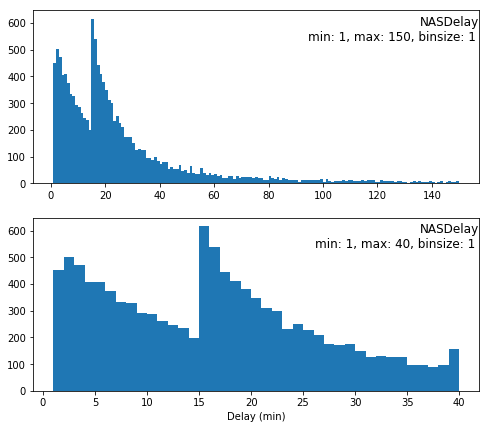

In [20]:
vars = ['NASDelay']
numPlots = 2;
for i in range(len(vars)):
    var = vars[i]
    min_values = [1, 1]
    max_values = [150, 40]
    binsizes = [1, 1]
    plot_histograms_stdAxis(flights, var, 'Delay (min)', numPlots, min_values, max_values, binsizes)

**'LateAircraftDelay' distribution**

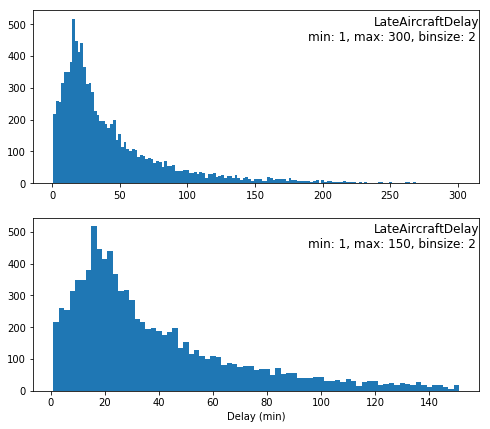

In [21]:
vars = ['LateAircraftDelay']
numPlots = 2;
for i in range(len(vars)):
    var = vars[i]
    min_values = [1, 1]
    max_values = [300, 150]
    binsizes = [2, 2]
    plot_histograms_stdAxis(flights, var, 'Delay (min)', numPlots, min_values, max_values, binsizes)

**Create log-scale histograms of 'ArrDelay' and 'DepDelay' variables**
* Start these histograms at a value larger than zero

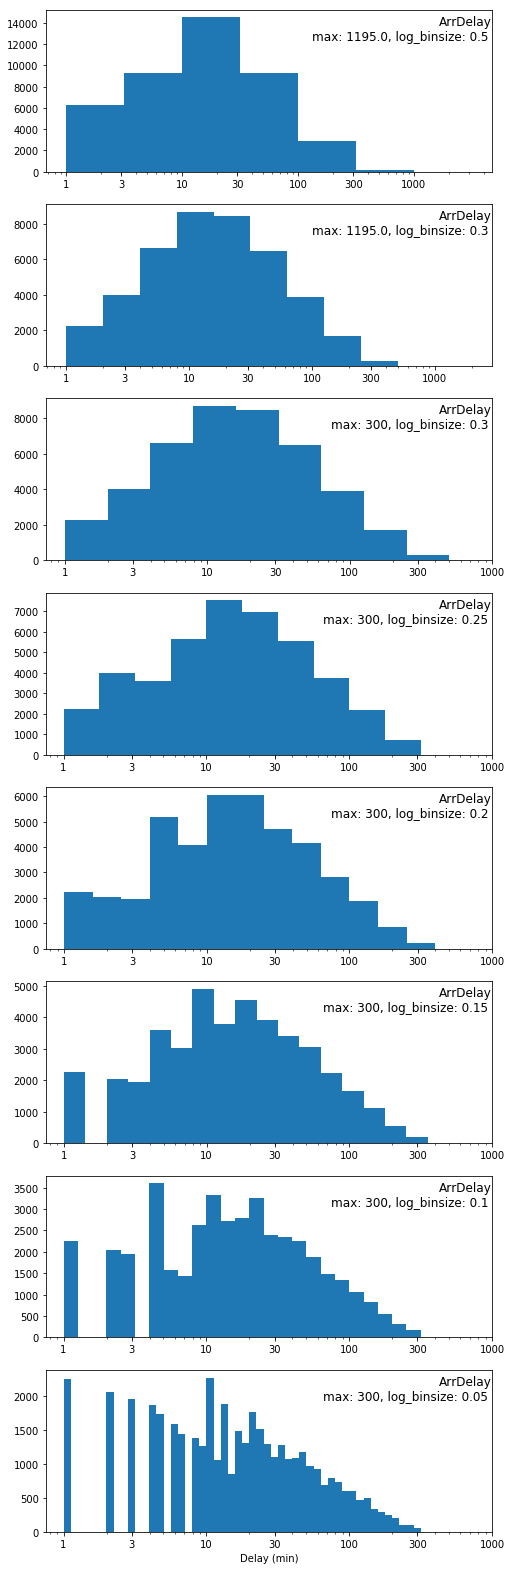

------------------------------------------------------------------------------------


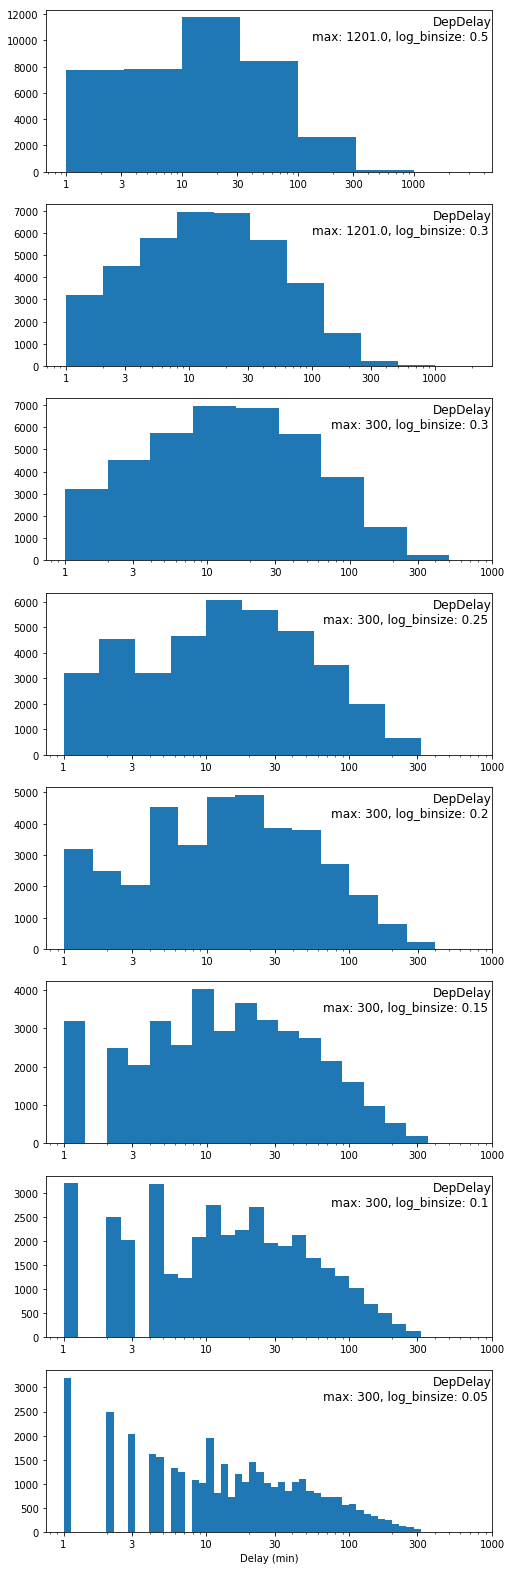

------------------------------------------------------------------------------------


In [22]:
vars = ['ArrDelay', 'DepDelay']
numPlots = 8;
for i in range(len(vars)):
    var = vars[i]
    max_values = [flights[var].max(),
                  flights[var].max(),
                  300, 300, 300, 300, 300, 300]
    log_binsizes = [0.5, 0.3, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]
    ticks = [1, 3, 10, 30, 100, 300, 1000]
    plot_histograms_logAxis(flights, var, 'Delay (min)', numPlots, max_values, log_binsizes, ticks)
    print('------------------------------------------------------------------------------------')

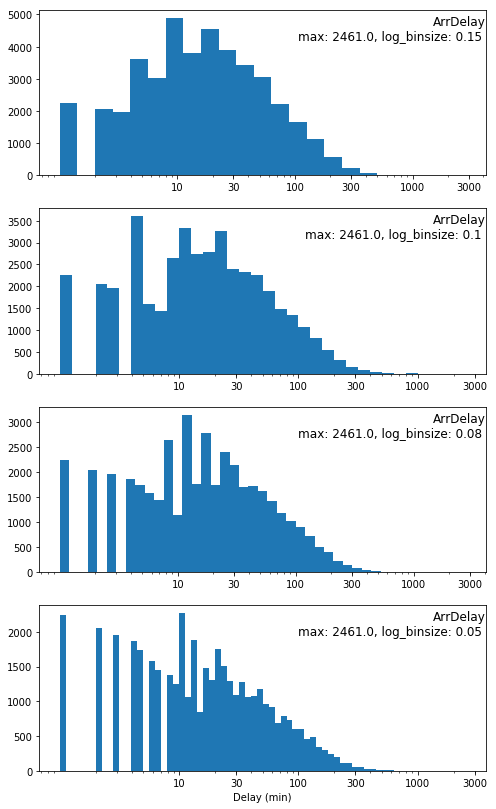

------------------------------------------------------------------------------------


In [24]:
vars = ['ArrDelay']
numPlots = 4;
for i in range(len(vars)):
    var = vars[i]
    max_values = [flights_all[var].max(),
                  flights_all[var].max(),
                  flights_all[var].max(), 
                  flights_all[var].max()]
    log_binsizes = [0.15, 0.1, 0.08, 0.05]
    #ticks = [1, 3, 10, 30, 100, 300, 1000, 3000]
    ticks = [10, 30, 100, 300, 1000, 3000]
    #ticks = [100, 300, 1000, 3000]
    plot_histograms_logAxis(flights, var, 'Delay (min)', numPlots, max_values, log_binsizes, ticks)
    print('------------------------------------------------------------------------------------')

<a id='univariate_delay_additional_observations'></a>
([Top of Page](#top_of_page))<br>

**'Delay' Variables - Additional Observations**

* Most 'Delay' variables appear to be roughly log-normal
* **'WeatherDelay'** - appears to be noisier than other delays. This is not surprising, given the unpredictable nature of weather events.
* **'NASDelay'** (i.e., National Air System Delay) - has a large spike in frequency at 15 minutes. This probably represents some sort of standard delay.
* **'LateAircraftDelay'** - has a spike at roughly 20 minutes, after which it is approximately logarithmic
* **'SecurityDelay'** - * It turns out this parameter is not _uniformly_ zero, but since it is _mostly_ zeros, this parameter is not a large driver of delays and will be ignored

**Select other variables for exploration**
* Start by previewing the columns and datatypes one more time

In [25]:
flights.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

Numerical variables of potential interest (create distributions):
* Month
* DepTime
* CRSDepTime
* ArrTime
* CRSArrTime
* ActualElapsedTime
* CRSElapsedTime
* AirTime
* Distance
* TaxiIn
* TaxiOut
* Cancelled
* Diverted

Categorical variables of potential interest (create bar plots):
* UniqueCarrier
* Origin
* Dest

In [26]:
vars_distr = ['Month', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime',
              'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted']

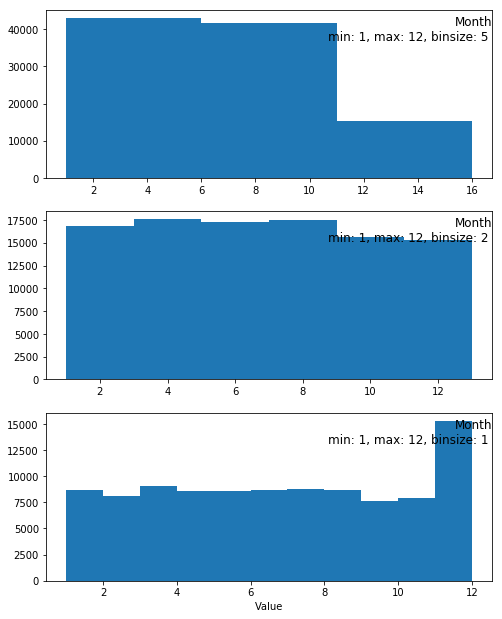

------------------------------------------------------------------------------------


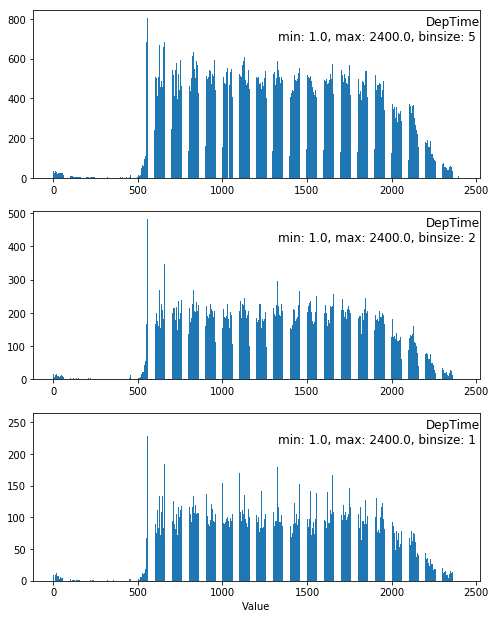

------------------------------------------------------------------------------------


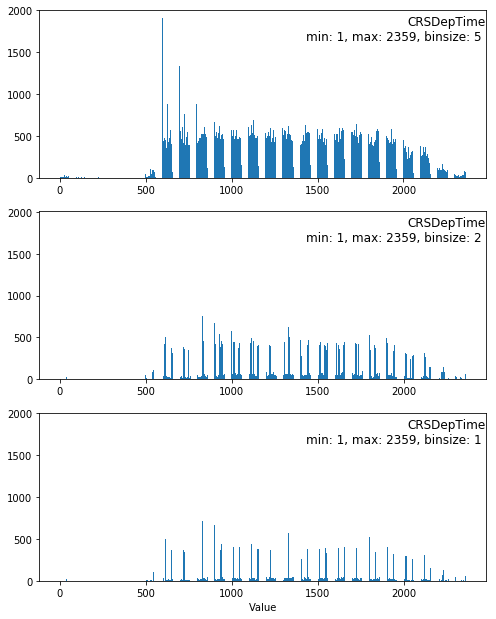

------------------------------------------------------------------------------------


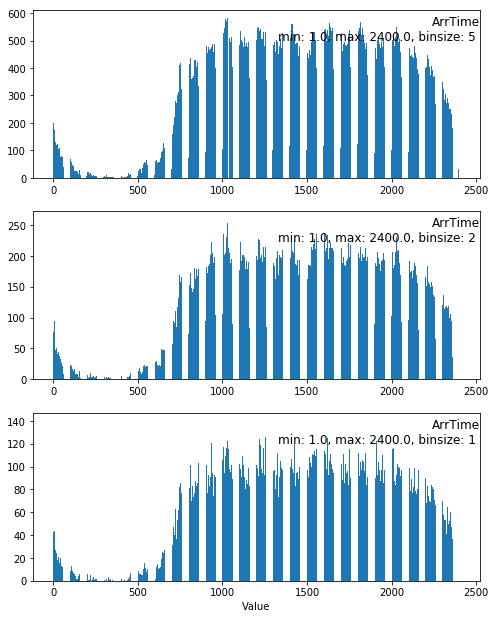

------------------------------------------------------------------------------------


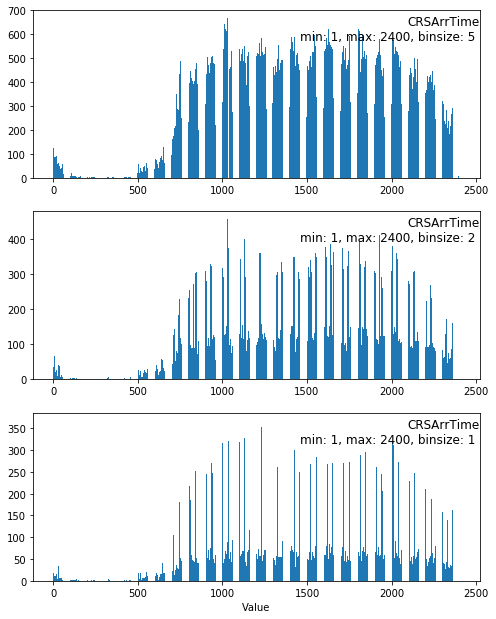

------------------------------------------------------------------------------------


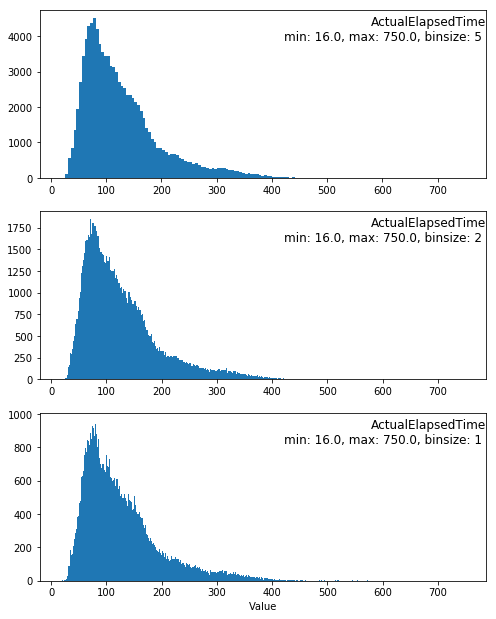

------------------------------------------------------------------------------------


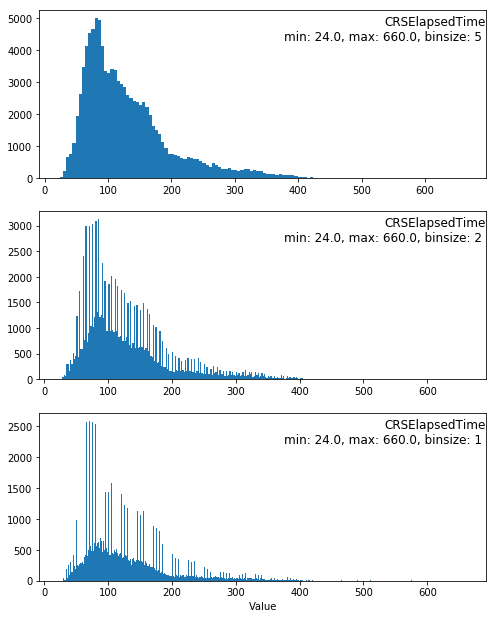

------------------------------------------------------------------------------------


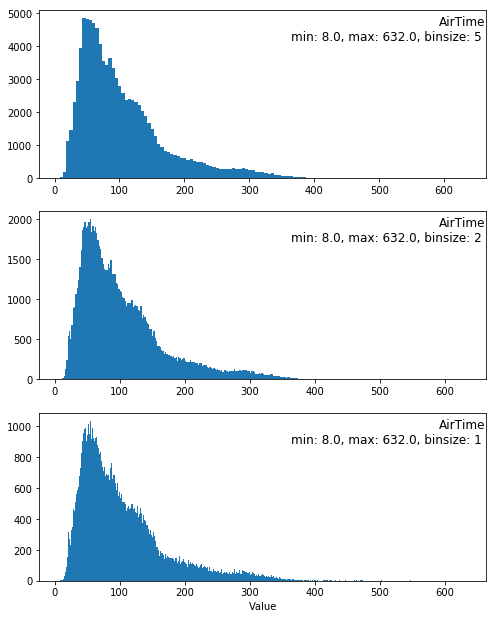

------------------------------------------------------------------------------------


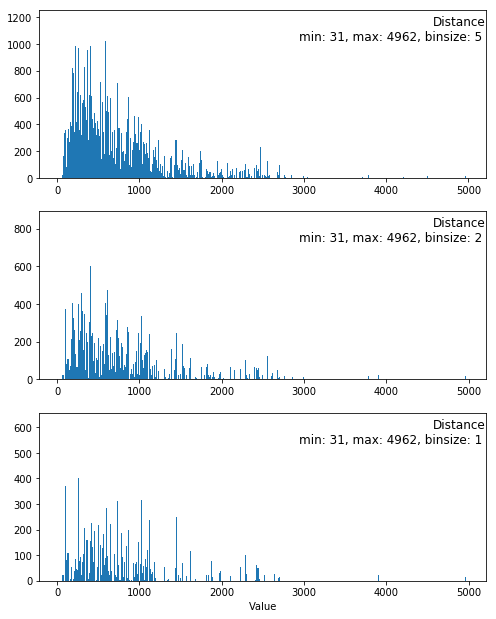

------------------------------------------------------------------------------------


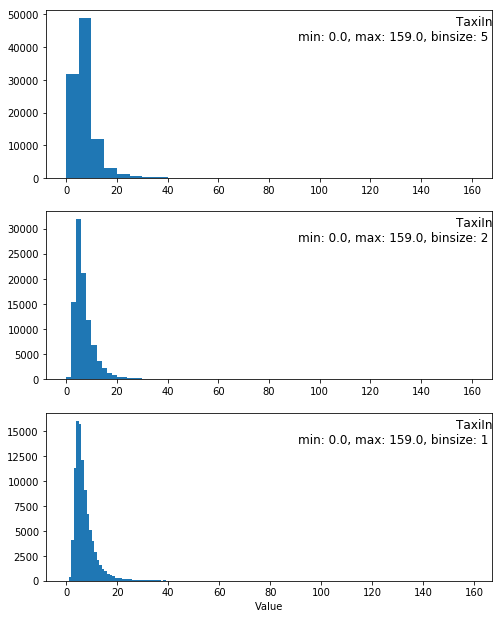

------------------------------------------------------------------------------------


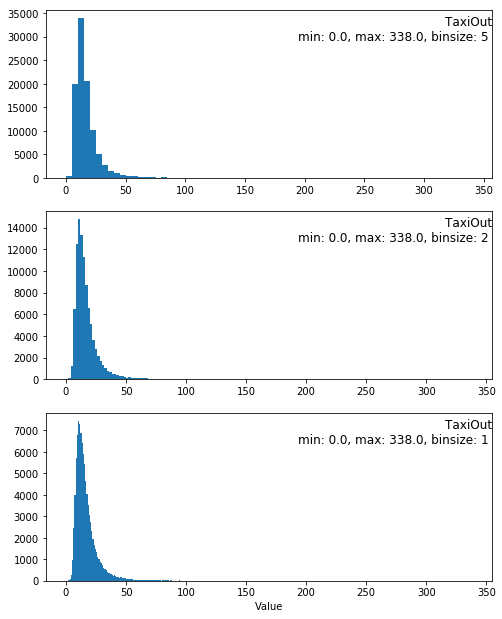

------------------------------------------------------------------------------------


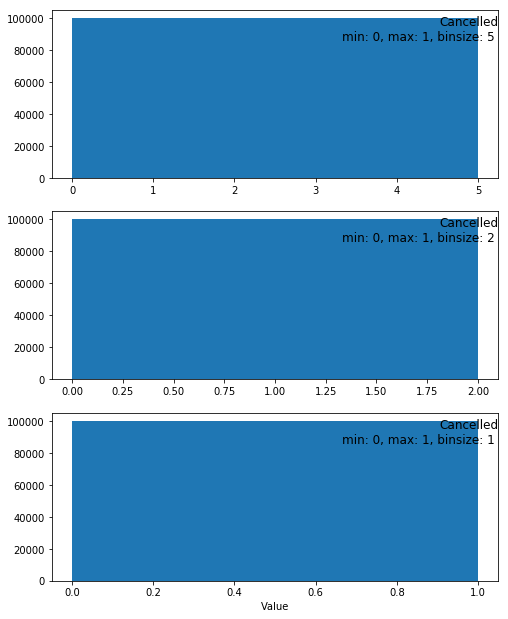

------------------------------------------------------------------------------------


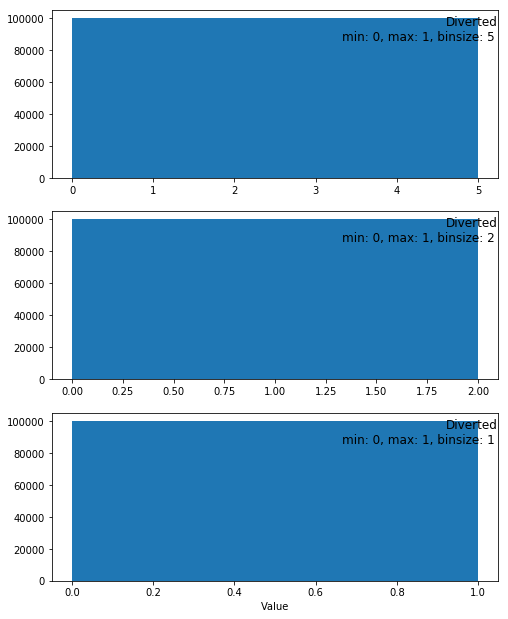

------------------------------------------------------------------------------------


In [27]:
numPlots = 3;
for i in range(len(vars_distr)):
    var = vars_distr[i]
    min_values = [flights[var].min(), flights[var].min(), flights[var].min()]
    max_values = [flights[var].max(), flights[var].max(), flights[var].max()]
    binsizes = [5, 2, 1]
    plot_histograms_stdAxis(flights, var, 'Value', numPlots, min_values, max_values, binsizes)
    print('------------------------------------------------------------------------------------')

**Zoom in on 'CRSElapsedTime' distribution**

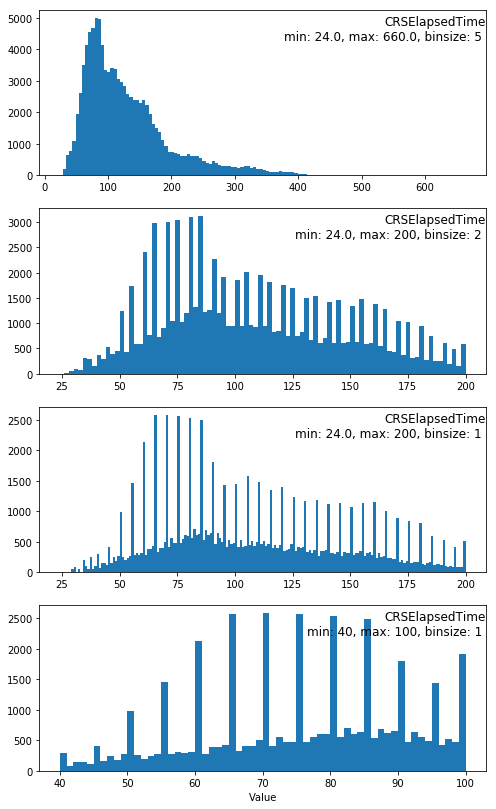

In [28]:
numPlots = 4;
var = 'CRSElapsedTime'
min_values = [flights[var].min(), flights[var].min(), flights[var].min(), 40]
max_values = [flights[var].max(), 200, 200, 100]
binsizes = [5, 2, 1, 1]
plot_histograms_stdAxis(flights, var, 'Value', numPlots, min_values, max_values, binsizes)

**Zoom in on 'Distance' distribution**

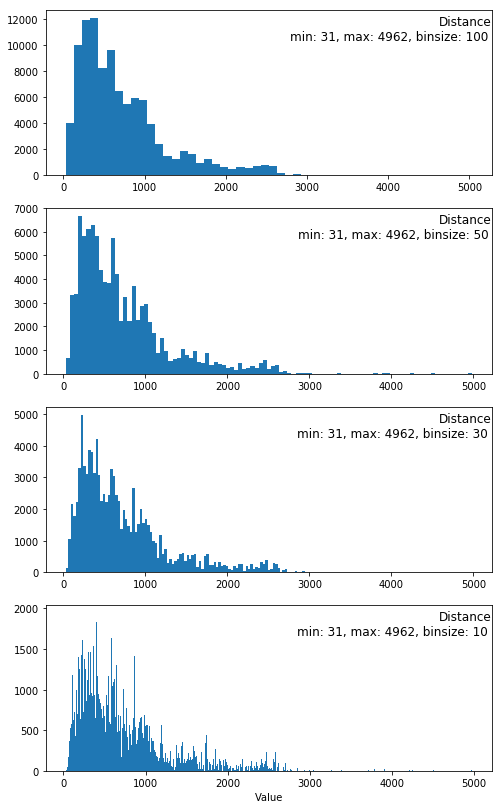

In [29]:
numPlots = 4;
var = 'Distance'
min_values = [flights[var].min(), flights[var].min(), flights[var].min(), flights[var].min()]
max_values = [flights[var].max(), flights[var].max(), flights[var].max(), flights[var].max()]
binsizes = [100, 50, 30, 10]
plot_histograms_stdAxis(flights, var, 'Value', numPlots, min_values, max_values, binsizes)

**Add 'Date', 'DayOfYear', and 'Week' parameters**

In [30]:
# add Date, Week, and DayOfYear parameters to the dataset
temp_date = pd.to_datetime(flights.Year*10000 +
                           flights.Month*100 +
                           flights.DayofMonth, format='%Y%m%d')
flights['Date'] = temp_date
flights['DayOfYear'] = flights['Date'].dt.dayofyear
flights['Week'] = flights['Date'].dt.week

# quick hack / correct issue where the last few days of the year errantly indicate 'Week' == 1
mask1 = flights.Month == 12
mask2 = flights.DayofMonth >= 29
flights.loc[mask1 & mask2, 'Week'] = 53

In [31]:
# also add Date, Week, DayOfYear parameters to the larger dataset (in case it is needed later)
temp_date = pd.to_datetime(flights_all.Year*10000 +
                           flights_all.Month*100 +
                           flights_all.DayofMonth, format='%Y%m%d')
flights_all['Date'] = temp_date
flights_all['DayOfYear'] = flights_all['Date'].dt.dayofyear
flights_all['Week'] = flights_all['Date'].dt.week

# quick hack / correct issue where the last few days of the year errantly indicate 'Week' == 1
mask1 = flights_all.Month == 12
mask2 = flights_all.DayofMonth >= 29
flights_all.loc[mask1 & mask2, 'Week'] = 53

**Plot the 'DayOfYear' distribution**

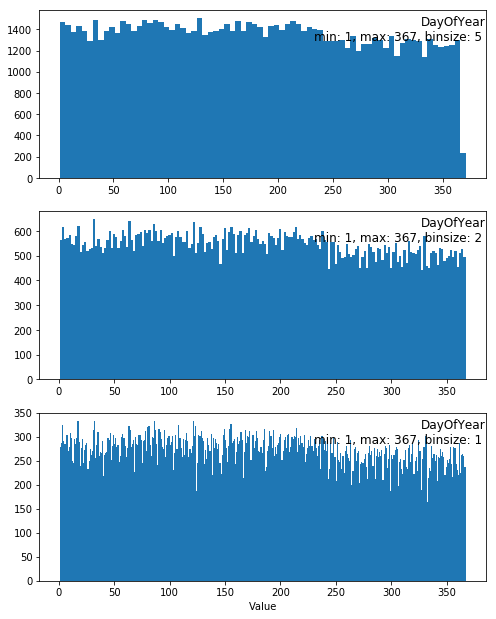

In [32]:
numPlots = 3;
var = 'DayOfYear'
min_values = [flights[var].min(), flights[var].min(), flights[var].min()]
max_values = [flights[var].max()+1, flights[var].max()+1, flights[var].max()+1]
binsizes = [5, 2, 1]
plot_histograms_stdAxis(flights, var, 'Value', numPlots, min_values, max_values, binsizes)

**Plot the 'Week' distribution**

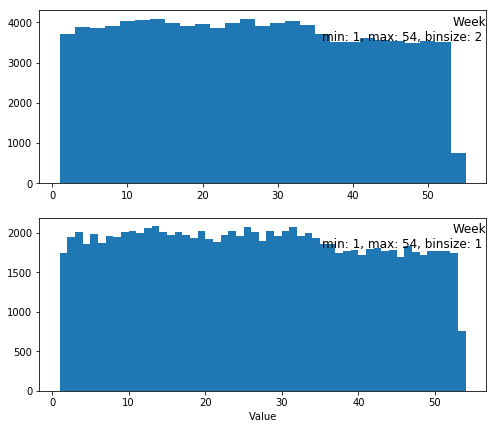

In [33]:
numPlots = 2;
var = 'Week'
min_values = [flights[var].min(), flights[var].min()]
max_values = [flights[var].max()+1, flights[var].max()+1]
binsizes = [2, 1]
plot_histograms_stdAxis(flights, var, 'Value', numPlots, min_values, max_values, binsizes)

<a id='univariate_otherVar_categorical'></a>
([Top of Page](#top_of_page))<br>

**Plot counts of categorical variables - top 10 for 'Origin', 'Dest', and 'UniqueCarrier'**

In [34]:
print(flights.groupby('Origin').Origin.count().sort_values(ascending=False).count())
print(flights.groupby('Dest').Dest.count().sort_values(ascending=False).count())
print(flights.groupby('UniqueCarrier').UniqueCarrier.count().sort_values(ascending=False).count())

299
297
20


In [35]:
origins = flights.groupby('Origin').Origin.count().sort_values(ascending=False)
destinations = flights.groupby('Dest').Dest.count().sort_values(ascending=False)
carriers = flights.groupby('UniqueCarrier').UniqueCarrier.count().sort_values(ascending=False)

origins_head = (origins.head(10)) 
destinations_head = (destinations.head(10)) 
carriers_head = (carriers.head(10)) 

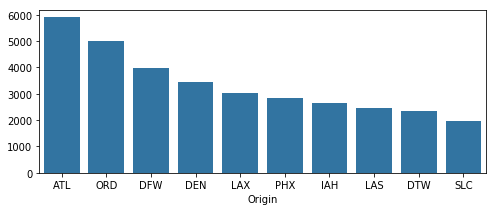

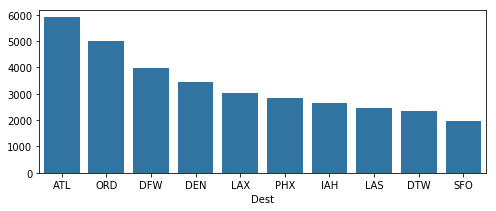

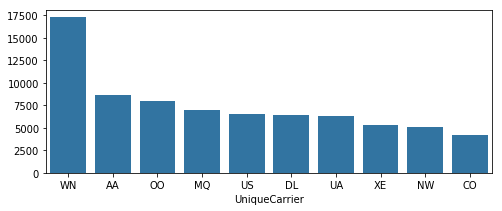

In [36]:
default_color = sb.color_palette()[0]

plt.figure(figsize = [8, 3])
ax = sb.barplot(origins_head.index, origins_head.values, color = default_color);

plt.figure(figsize = [8, 3])
ax = sb.barplot(destinations_head.index, origins_head.values, color = default_color);

plt.figure(figsize = [8, 3])
ax = sb.barplot(carriers_head.index, carriers_head.values, color = default_color);

In [37]:
top10_origin = flights.groupby('Origin').Origin.count().sort_values(ascending=False)[0:10].index.tolist()
top10_dest = flights.groupby('Dest').Origin.count().sort_values(ascending=False)[0:10].index.tolist()
top10_carrier = flights.groupby('UniqueCarrier').UniqueCarrier.count().sort_values(ascending=False)[0:10].index.tolist()
print(top10_origin, '\n---------\n', top10_carrier)

['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'PHX', 'IAH', 'LAS', 'DTW', 'SLC'] 
---------
 ['WN', 'AA', 'OO', 'MQ', 'US', 'DL', 'UA', 'XE', 'NW', 'CO']


<a id='univariate_otherVar_observations'></a>
([Top of Page](#top_of_page))<br>

**Other Variables - Observations:**

* **'Month'** - The number of flights spikes during December. I am not surprised by this, but I find the magnitude of the spike interesting.
* **'DepTime'**:
  - There are very few departures between 12:00 am and 5:00 am
* **'CRSDepTime'**
  - There are a large number of departures _scheduled_ for 6:00 am and 7:00 am.
  - Departures are frequently scheduled on the hour or on the half hour
* **'ArrTime'** - The number of arrivals is roughly constant from 10:00 am to 10:00 pm.
* **'ActualElapsedTime'** - The most frequent elapsed time is ~90 minutes
* **'CRSElapsedTime'** - Flight lengths have a tendency to be scheduled on 5 minute intervals
* **'AirTime'** and **'Distance'** - There is some slight multi-modality to these variables
  - This probably reflects different 'tiers' of flights involving distance and/or aircraft type
* **'DayOfYear'**
  - the histograms show a consistent number of flights throughout the year
  - I would have thought that there would be an increase in flights duing the holidays
  - Perhaps the holidays just have an increase in passengers instead of flights
    - I could see how the airlines might fly fuller and/or larger planes during the holidays to accomodate the increase in passengers
    - I assume there is an actual increase in number of travelers during the holidays, but this dataset does not provide number of passengers
* **'Origin'** and **'Dest'**
  - There are ~300 different airports represtented by each of these variables
  - To focus things, I will only analyze the top 5 to 10 airports in subsequent plots
* **'UniqueCarrier'**
  - Similar to **'Origin'** and **'Dest'**, I will only analyze the top 5 to carriers in subsequent plots (in order to focus the analysis)

<a id='univariate_exploration_summary'></a>
([Top of Page](#top_of_page))
## Univariate Exploration - Summary

<a id='univariate_exploration_describe_distributions_of_interest'></a>
([Top of Page](#top_of_page))
### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

**Observations (largely repeated from prior comments):**
* Most 'Delay' variables appear to be roughly log-normal.
  * Depending on the particular visualization, it may be useful to log transform these variables in future plots.
* **'CarrierDelay', 'WeatherDelay', 'NASDelay',** and **'LateAircraftDelay'**:
  * Each have a large number of points at or very near zero.
  * This disguises the true nature of these distributions.
  * Future plots utilizing these parameters may need to filter for values greater than zero
* **'NASDelay'** (i.e., National Air System Delay):
  * Has a large spike in frequency at 15 minutes. This probably represents some sort of standard delay.
* **'LateAircraftDelay'**:
  * Has a spike at roughly 20 minutes, after which it is approximately logarithmic
* **'WeatherDelay'**:
  * Appears to be noisier than other delays. This is not surprising, given the unpredictable nature of weather events.
* **'SecurityDelay'**
  * is not _uniformly_ zero values, but it is _mostly_ zero values
  * as such, this parameter is not a large driver of delays and will be ignored
* **'Month'**
  * The number of flights spikes during December. I am not surprised by this, but I find the magnitude of the spike interesting.
* **'DepTime'**:
  * There are very few departures between 12:00 am and 5:00 am
* **'CRSDepTime'**
  * There are a large number of departures _scheduled_ for 6:00 am and 7:00 am.
  * Departures are frequently scheduled on the hour or on the half hour
* **'ArrTime'**
  * The number of arrivals is roughly constant from 10:00 am to 10:00 pm.
* **'ActualElapsedTime'**
  * The most frequent elapsed time is ~90 minutes
* **'CRSElapsedTime'**
  * Flight lengths have a tendency to be scheduled on 5 minute intervals
* **'AirTime'** and **'Distance'**
  * There is some slight multi-modality to these variables
  * This probably reflects different 'tiers' of flights involving distance and/or aircraft type
* **'DayOfYear'**
  - the histograms show a consistent number of flights throughout the year
  - I would have thought that there would be an increase in flights duing the holidays
  - Perhaps the holidays just have an increase in passengers instead of flights
    - I could see how the airlines might fly fuller and/or larger planes during the holidays to accomodate the increase in passengers
    - I assume there is an actual increase in number of travelers during the holidays, but this dataset does not provide number of passengers
* **'Origin'** and **'Dest'**
  - There are ~300 different airports represtented by each of these variables
  - To focus things, I will only analyze the top 5 to 10 airports in subsequent plots
* **'UniqueCarrier'**
  - Similar to **'Origin'** and **'Dest'**, I will only analyze the top 5 to carriers in subsequent plots (in order to focus the analysis)
  
**Most likely variables of interest:**
* The various 'Delay' variables
  * notably:  **'ArrDelay'** and **'DepDelay'**
* **'DayOfYear'**
* **'Week'**
* **'Origin'**
* **'Dest'**
* **'UniqueCarrier'**

<a id='univariate_exploration_unusual_distributions_and_modifications'></a>
([Top of Page](#top_of_page))
### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

* **The nature of several distributions is discussed in the section immediately preceeding this question**
<br><br>

* **I performed very little cleaning or tidying of the data.**
  * Although there are several NAN values in the various delay parameters, I chose not to delete these because there is a lot of other data in those rows that is still valid.
  * I also chose not to fill NaN's with zeros, since that would skew the statistics of various parameers.
  * I took the same approach with outliers: choosing not to modify them in order to maintain the integrity of the data.
  * To get around the unusual distribution, NaN, and outlier issues, I intend to specify (where appropriate) axis limits and/or axis transformations on future plots
  * Overall, the dataset is fairly clean as-is, and cleaning it would result in significant loss and/or corruption of data.
<br><br>

* **I did add three new features: 'Date' 'Week' and 'DayOfYear'**
  * **'Date'** 
    * added to make use of 'DateTime' methods
    * Creating a **'Date'** feature enabled the subsequent creation of the **'Week'** and **'DayOfYear'** features, which I consider to be necessary features
  * **'Week'**
    * Added to have a quick and easy way to view data over the course of the year
  * **DayOfYear**
    * Similar to **'Week'**, this was added to have a quick and easy way to view data over the course of the year
    * However, this variable will allow for a finer level of granularity than the **'Week'** variable

<a id='bivariate_exploration'></a>
([Top of Page](#top_of_page))
## Bivariate Exploration

**Initial approach:**
* I am going to start by looking at correlations between the various parameters in an attempt to understand what affects the delay variables
* I plan to do this by creating correlation heat maps

<a id='bivariate_exploration_heatMaps'></a>
([Top of Page](#top_of_page))
### Correlation Heat Maps

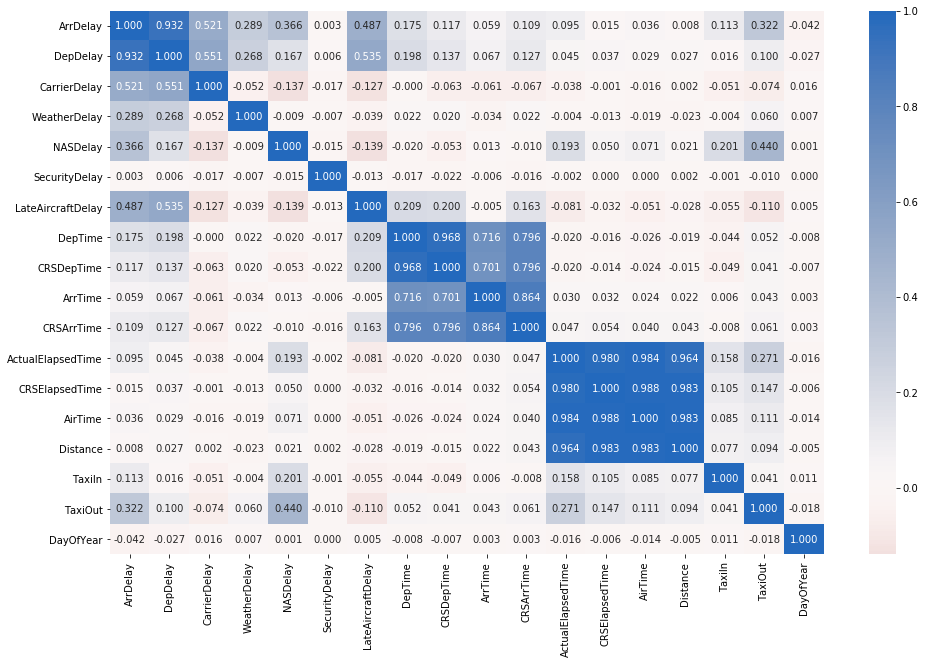

In [38]:
#choose vars to explore
vars = ['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
        'LateAircraftDelay', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime',
        'CRSElapsedTime', 'AirTime', 'Distance', 'TaxiIn', 'TaxiOut', 'DayOfYear']

# correlation plot
plt.figure(figsize = [16, 10])
sb.heatmap(flights[vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0)
plt.show()

* **Initial Observations:**
  * **'SecurityDelay'** does not correlate to any other variables. It should be removed from consideration
  * **'DayOfYear'** also does not correlate to any other variables
    * However, I suspect any correlation between **'DayOfYear'** and other variables is complex in nature and is affected by interactions with third and fourth order variables, such as **'Origin'**, **'Dest'**, **'UniqueCarrier'**, **'WeatherDelay'**, etc.
    * **'DayOfYear'** will be removed from consideration at this time. However, it will likely be a good parameter to analyze during multivariate exploration
  * **'ActualElaspedTime', 'CRSElapsedTime', 'AirTime',** and **'Distance'** are only significantly correlated with one another. They should be removed from consideration.
    * However, **'ActualElaspedTime'** and **'CRSElapsedTime'** do have a correlation with **'TaxiIn'** and **'TaxiOut'**
    * If **'TaxiIn'** and **'TaxiOut'** become parameters of interest, this may be worth remembering  

**Remove 'SecurityDelay', 'ActualElaspedTime', 'CRSElapsedTime', 'AirTime', 'Distance', and 'DayOfYear' from the heat map:**

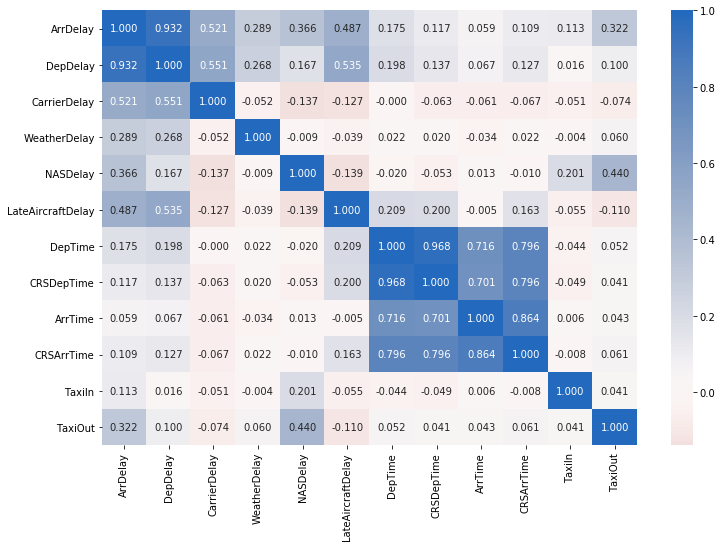

In [39]:
#choose vars to explore (removed: 'SecurityDelay', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'Distance')
vars = ['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay',
        'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'TaxiIn', 'TaxiOut']

# correlation plot
plt.figure(figsize = [12, 8])
sb.heatmap(flights[vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0)
plt.show()

**Look at a heat map with just the delay variables, along with \['DepTime', 'CRSDepTime', 'TaxiIn', 'TaxiOut'\] to see if it makes more sense or if anything else sticks out**

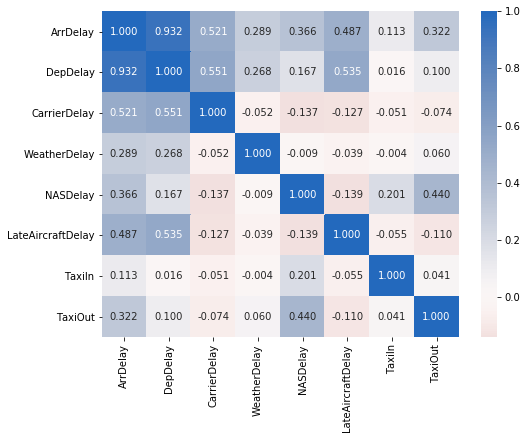

In [40]:
#choose vars to explore (removed: 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime')
vars = ['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay',
        'TaxiIn', 'TaxiOut']

# correlation plot
plt.figure(figsize = [8, 6])
sb.heatmap(flights[vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0)
plt.show()

* **Recall from univariate exploration:**
  * **'CarrierDelay', 'WeatherDelay', 'NASDelay',** and **'LateAircraftDelay'** each have a large number of points at or very near zero. This is disguising the true nature of these distributions.
<br><br>

* **Based on this, it might be useful to look at correlations where those variables are not zero**
<br><br>

* **Planned approach:**
  * Since the df.corr() method returns a succinct dataframe "matrix" with variable names and their corresponding correlation coefficients, I just need to create a custom version of that matrix
  * I will create multiple two-column dataframes wherein one column (the 'filter' variable) is a given parameter filtered to be > 0 and the second column (the 'comparison' variable) contains the corresponding values of a second parameter
  * I will then populate my custom correlation matrix one element at a time

In [41]:
def filter_zeros(df, varCompare, varFilt):
    mask = df[varFilt] > 0
    df = df[mask]
    df = df[[varCompare, varFilt]]
    return df

In [42]:
varsCorr = ['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
             'LateAircraftDelay', 'TaxiIn', 'TaxiOut']
varsFilt = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']

In [43]:
flights_varsCorr = pd.DataFrame(index=varsCorr, columns=varsCorr)

for i in range(len(varsCorr)):
    
    # debug statements
    #print('\'' + varsCorr[i] + '\': ' + str(flights[varsCorr[i]].count()) + ' rows')
        
    for j in range(len(varsCorr)):
        
        # case: variable being assessed against itself
        if varsCorr[i] == varsCorr[j]:
            current_corr = 1
            
            # debug statements
            #print('     1,  corr,shape w/ ' + varsCorr[j] + ': ' + str(current_corr) + 
            #      ', i_count:' + str(flights[varsCorr[i]].count()) + 
            #      ', j_count:' + str(flights[varsCorr[j]].count()))
            
        # case: 'comparison' variable being assessed against a 'filter' variable
        elif varsCorr[j] in varsFilt:
            df_twoVars = filter_zeros(flights, varsCorr[i], varsCorr[j])  # return 2 var df, filtered vars[j]>0
            current_corr = df_twoVars[varsCorr[i]].corr(df_twoVars[varsCorr[j]])
            
            # debug statements
            #print('    f1,  corr,shape w/ ' + varsCorr[j] + ': ' + str(current_corr) + 
            #      ', i_count:' + str(df_twoVars[varsCorr[i]].count()) + 
            #      ', j_count:' + str(df_twoVars[varsCorr[j]].count()))
            
        # base case: non-delay variable assessed against a non-delay variable
        else:
            current_corr = flights[varsCorr[i]].corr(flights[varsCorr[j]])
            
            # debug statements
            #print('   reg, corr,shape w/ ' + varsCorr[j] + ': ' + str(current_corr) + 
            #      ', i_count:' + str(flights[varsCorr[i]].count()) + 
            #      ', j_count:' + str(flights[varsCorr[j]].count()))
        
        flights_varsCorr.loc[varsCorr[i]][varsCorr[j]] = current_corr

# debug statements
#flights_varsCorr

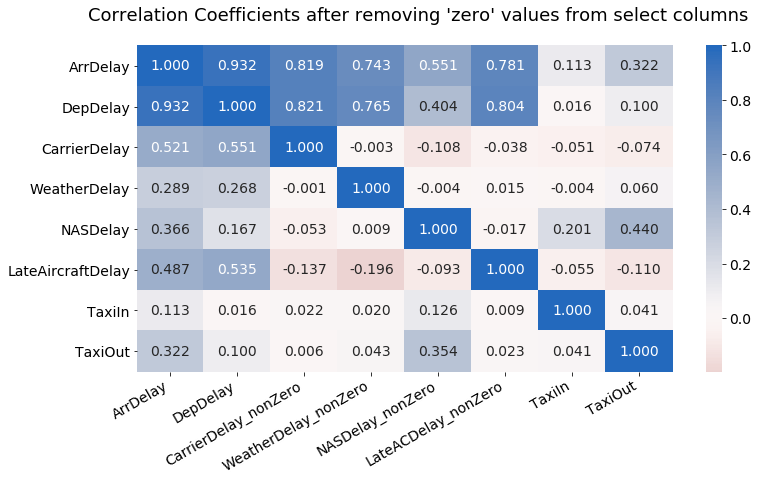

In [44]:
varsCorr_nonZero = ['ArrDelay', 'DepDelay', 'CarrierDelay_nonZero', 'WeatherDelay_nonZero', 'NASDelay_nonZero',
             'LateACDelay_nonZero', 'TaxiIn', 'TaxiOut']

# convert from string to float
for i in range(len(varsCorr)):
    flights_varsCorr[varsCorr[i]] = flights_varsCorr[varsCorr[i]].astype(float)

# correlation plot
plt.figure(figsize = [12, 6])
ax = sb.heatmap(flights_varsCorr, annot = True, fmt = '.3f', annot_kws={"size": 14},
           cmap = 'vlag_r', center = 0,
           xticklabels=varsCorr_nonZero)
ax.figure.axes[-1].tick_params(labelsize=14)
ax.tick_params(labelsize=14)
plt.xticks(rotation=30, ha='right')

title_string=('Correlation Coefficients after removing \'zero\' values from select columns')
plt.suptitle(title_string, x=0.45, y=0.97, fontsize=18)
plt.show()

**Observations:**
* When zero values are removed, **'ArrDelay'** and **'DepDelay'** are most strongly correlated with **'CarrierDelay'**, **'WeatherDelay'**, and **'LateAircraftDelay'**
* Removing zeros causes:
  **'WeatherDelay'** to be more strongly correlated with **'ArrDelay'** and **'DepDelay'** than **'NASDelay'**
    * This implies that Weather Delays happen less often than NAS Delays, but have a larger impact on arrival and departure delays
* Since a non-zero **'WeatherDelay'** has a strong correlation to **'ArrDelay'** (and **'DepDelay'**) and since **'WeatherDelay'** appears to happen less often than other delay types, I suspect it is a significant swing factor  affecting Arrival and Departure delays

**Next, I am going to create some violin plots to assess how the distributions of ArrDelay and DepDelay vary based on a second variable:**
* Second variables of interest: Origin (airport) and Unique Carrier (airline)
* To focus the analysis, I am only going to look at the top 10 most frequented airports and airlines

<a id='bivariate_exploration_violinPlots'></a>
([Top of Page](#top_of_page))
### Violin Plots

In [45]:
print(top10_origin, '\n---------\n', top10_carrier)

['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'PHX', 'IAH', 'LAS', 'DTW', 'SLC'] 
---------
 ['WN', 'AA', 'OO', 'MQ', 'US', 'DL', 'UA', 'XE', 'NW', 'CO']


In [ ]:
# flights_reduced_orig = flights[flights.Origin.isin(top10_origin)]
# flights_reduced_orig = flights_reduced_orig[flights_reduced_orig.UniqueCarrier.isin(top10_carrier)]
# 
# flights_reduced_dest = flights[flights.Dest.isin(top10_origin)]
# flights_reduced_dest = flights_reduced_dest[flights_reduced_dest.UniqueCarrier.isin(top10_carrier)]

In [46]:
default_color = sb.color_palette()[0]

In [47]:
flights_reduced_orig = flights[flights.Origin.isin(top10_origin)]
flights_reduced_dest = flights[flights.Dest.isin(top10_dest)]
flights_reduced_carrier = flights[flights.UniqueCarrier.isin(top10_carrier)]

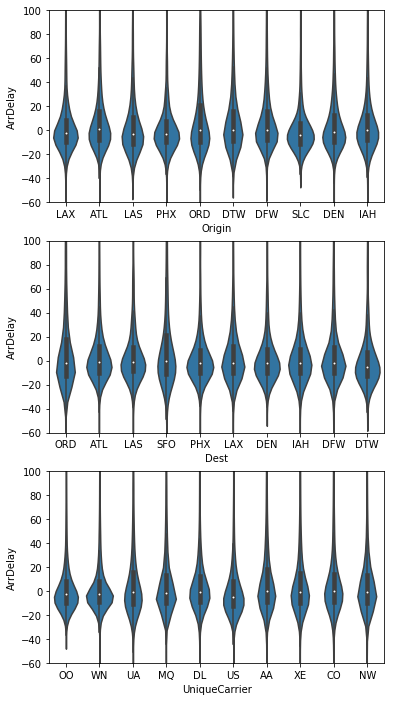

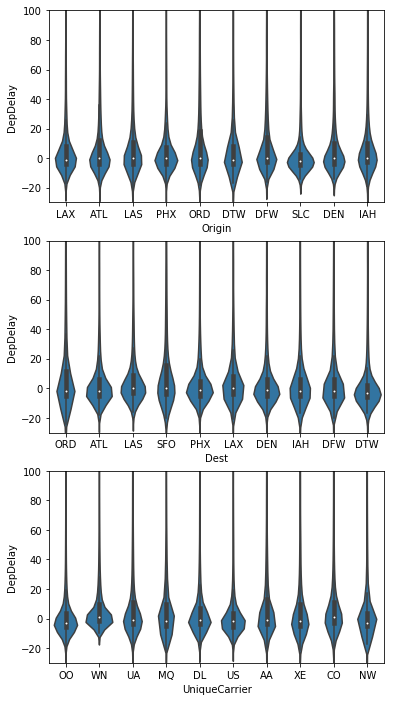

In [48]:
# plot arrival delay distribution against origin, dest, and unique carrier
categoric_vars = ['Origin', 'Dest', 'UniqueCarrier']
fig, ax = plt.subplots(ncols = 1, nrows = len(categoric_vars), figsize = [6,4*len(categoric_vars)], squeeze=False)
for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    if var == 'Origin':
        sb.violinplot(data = flights_reduced_orig, x = var, y = 'ArrDelay', ax = ax[i,0], color = default_color)
    elif var == 'Dest':
        sb.violinplot(data = flights_reduced_dest, x = var, y = 'ArrDelay', ax = ax[i,0], color = default_color)
    else:
        sb.violinplot(data = flights_reduced_carrier, x = var, y = 'ArrDelay', ax = ax[i,0], color = default_color)
    ax[i,0].set(ylim=(-60,100))
plt.show()

# plot departure delay distribution against origin, dest, and unique carrier
categoric_vars = ['Origin', 'Dest', 'UniqueCarrier']
fig, ax = plt.subplots(ncols = 1, nrows = len(categoric_vars), figsize = [6,4*len(categoric_vars)], squeeze=False)
for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    if var == 'Origin':
        sb.violinplot(data = flights_reduced_orig, x = var, y = 'DepDelay', ax = ax[i,0], color = default_color)
    elif var == 'Dest':
        sb.violinplot(data = flights_reduced_dest, x = var, y = 'DepDelay', ax = ax[i,0], color = default_color)
    else:
        sb.violinplot(data = flights_reduced_carrier, x = var, y = 'DepDelay', ax = ax[i,0], color = default_color)
    ax[i,0].set(ylim=(-30,100))
plt.show()

**Observations:**
* There doesn't seem to be much appreciable difference between the distributions
* However, a horizontal aspect would be easier to read
* Also, the axis needs to be altered: either a log scale or changing the limits will work.

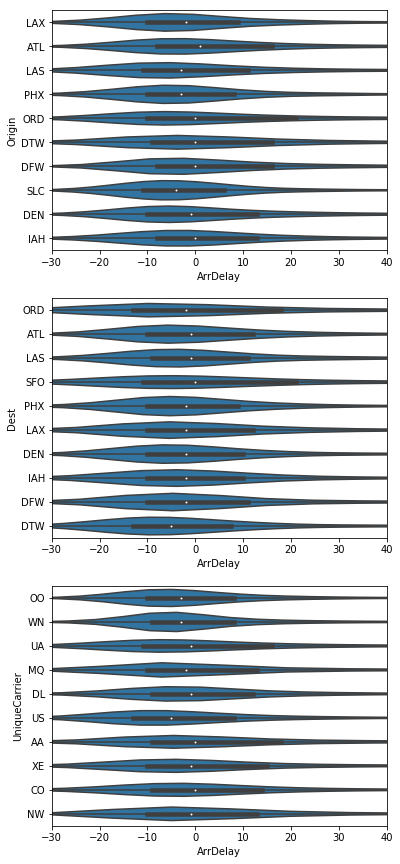

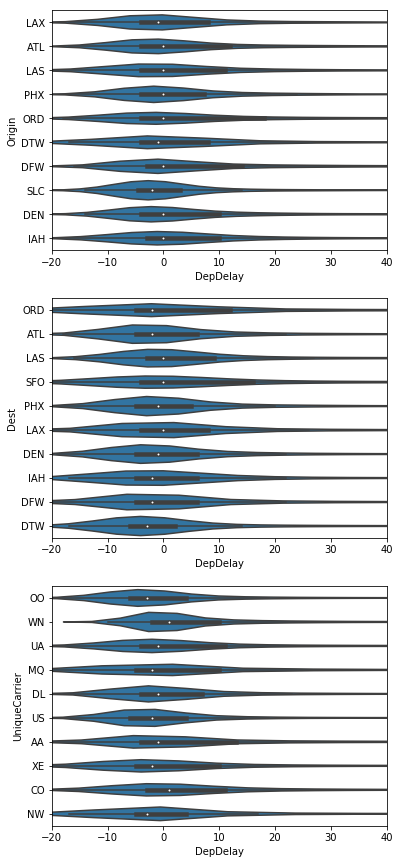

In [49]:
# plot arrival delay distribution against origin, dest, and unique carrier
categoric_vars = ['Origin', 'Dest', 'UniqueCarrier']
fig, ax = plt.subplots(ncols = 1, nrows = len(categoric_vars), figsize = [6,5*len(categoric_vars)], squeeze=False)
for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    if var == 'Origin':
        sb.violinplot(data = flights_reduced_orig, y = var, x = 'ArrDelay', ax = ax[i,0], color = default_color)
    elif var == 'Dest':
        sb.violinplot(data = flights_reduced_dest, y = var, x = 'ArrDelay', ax = ax[i,0], color = default_color)
    else:
        sb.violinplot(data = flights_reduced_carrier, y = var, x = 'ArrDelay', ax = ax[i,0], color = default_color)
    ax[i,0].set(xlim=(-30,40))
plt.show()

# plot departure delay distribution against origin, dest, and unique carrier
categoric_vars = ['Origin', 'Dest', 'UniqueCarrier']
fig, ax = plt.subplots(ncols = 1, nrows = len(categoric_vars), figsize = [6,5*len(categoric_vars)], squeeze=False)
for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    if var == 'Origin':
        sb.violinplot(data = flights_reduced_orig, y = var, x = 'DepDelay', ax = ax[i,0], color = default_color)
    elif var == 'Dest':
        sb.violinplot(data = flights_reduced_dest, y = var, x = 'DepDelay', ax = ax[i,0], color = default_color)
    else:
        sb.violinplot(data = flights_reduced_carrier, y = var, x = 'DepDelay', ax = ax[i,0], color = default_color)
    ax[i,0].set(xlim=(-20,40))
plt.show()

**Observations:**
* There still doesn't seem to be much appreciable difference between the distributions
* I suspect just looking at the box plots may be more visually intuitive

<a id='bivariate_exploration_boxPlots'></a>
([Top of Page](#top_of_page))
### Box Plots
**Create some Box Plots to better assess the nature of each distribution**

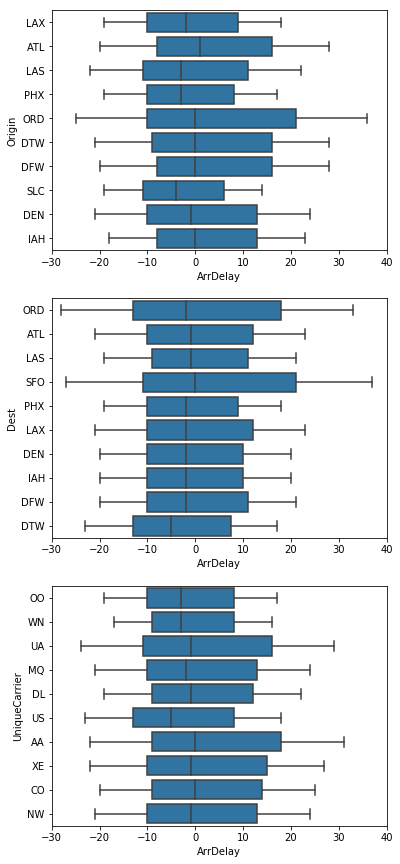

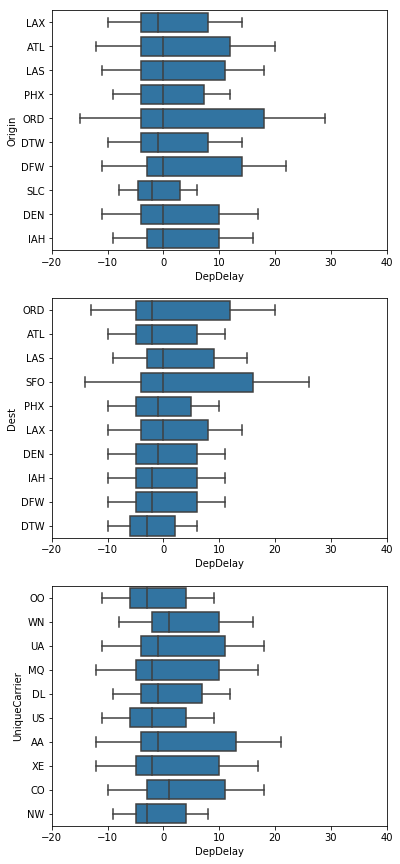

In [50]:
# plot arrival delay distribution against origin, dest, and unique carrier
categoric_vars = ['Origin', 'Dest', 'UniqueCarrier']
fig, ax = plt.subplots(ncols = 1, nrows = len(categoric_vars), figsize = [6,5*len(categoric_vars)], squeeze=False)
for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    if var == 'Origin':
        #sb.violinplot(data = flights_reduced_orig, y = var, x = 'ArrDelay', ax = ax[i,0], color = default_color)
        sb.boxplot(data=flights_reduced_orig, y=var, x='ArrDelay', ax=ax[i,0], color=default_color, whis=0.5, sym='')
    elif var == 'Dest':
        #sb.violinplot(data = flights_reduced_dest, y = var, x = 'ArrDelay', ax = ax[i,0], color = default_color)
        sb.boxplot(data=flights_reduced_dest, y=var, x='ArrDelay', ax=ax[i,0], color=default_color, whis=0.5, sym='')
    else:
        #sb.violinplot(data = flights_reduced_carrier, y = var, x = 'ArrDelay', ax = ax[i,0], color = default_color)
        sb.boxplot(data=flights_reduced_carrier, y=var, x='ArrDelay', ax=ax[i,0], color=default_color, whis=0.5, sym='')
    ax[i,0].set(xlim=(-30,40))
plt.show()

# plot departure delay distribution against origin, dest, and unique carrier
categoric_vars = ['Origin', 'Dest', 'UniqueCarrier']
fig, ax = plt.subplots(ncols = 1, nrows = len(categoric_vars), figsize = [6,5*len(categoric_vars)], squeeze=False)
for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    if var == 'Origin':
        #sb.violinplot(data = flights_reduced_orig, y = var, x = 'DepDelay', ax = ax[i,0], color = default_color)
        sb.boxplot(data=flights_reduced_orig, y=var, x='DepDelay', ax=ax[i,0], color=default_color, whis=0.5, sym='')
    elif var == 'Dest':
        #sb.violinplot(data = flights_reduced_dest, y = var, x = 'DepDelay', ax = ax[i,0], color = default_color)
        sb.boxplot(data=flights_reduced_dest, y=var, x='DepDelay', ax=ax[i,0], color=default_color, whis=0.5, sym='')
    else:
        #sb.violinplot(data = flights_reduced_carrier, y = var, x = 'DepDelay', ax = ax[i,0], color = default_color)
        sb.boxplot(data=flights_reduced_carrier, y=var, x='DepDelay', ax=ax[i,0], color=default_color, whis=0.5, sym='')
    ax[i,0].set(xlim=(-20,40))
plt.show()

<a id='bivariate_exploration_boxPlot_observations'></a>
([Top of Page](#top_of_page))<br><br>
**Box Plot Observations:**
* Airports
  * Arrival: ORD and SFO are capable of higher arrival delays (75% quartile values) than other top 10 destinations
    * based on second box plot of 'Dest' vs 'ArrDelay
  * Departure: ORD, DFW, and SFO are capable of higher departure delays (75% quartile values) than other top 10 origins
* Airlines
  * Arrival:
    * UA, AA, MQ, and CO are capable of higher arrival delays (75% quartile values) than other top 10 airlines
    * US has the lowest median arrival delay
  * Depature: UA and AA are capable of higher departure delays (75% quartile values) than other top 10 airlines
  * WN has the one of the lowest median arrival delays, but also has highest median departure delay. That is an interesting juxtaposition
* The box plots are indeed more intuitive than violin plots for assessing the differences in the distributions 

<a id='bivariate_exploration_2D_Histograms'></a>
([Top of Page](#top_of_page))
### 2D Histograms

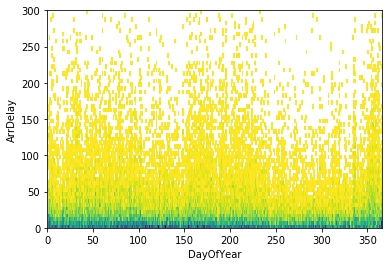

In [51]:
# hist2d returns a number of different variables, including an array of counts
bins_x = np.arange(0, 366+1, 1)
bins_y = np.arange(0, 300+5, 5)
h2d = plt.hist2d(data = flights, y = 'ArrDelay', x = 'DayOfYear',
               bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 1)
plt.ylabel('ArrDelay')
plt.xlabel('DayOfYear');

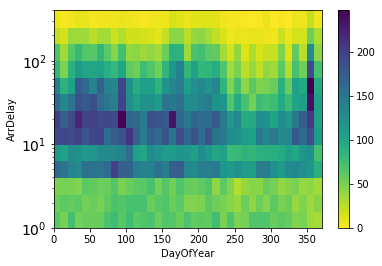

In [52]:
x = flights['DayOfYear']
y = flights['ArrDelay']

x_min_val = 0
x_max_val = 366
x_binSize = 10
x_bin_edges = np.arange(x_min_val, x_max_val+x_binSize, x_binSize)

y_min_val = 0
y_max_val = 300
y_logBinSize = 0.2
y_bin_edges = 10 ** np.arange(y_min_val, np.log10(y_max_val)+y_logBinSize, y_logBinSize)

counts, _, _ = np.histogram2d(x, y, bins=(x_bin_edges, y_bin_edges))

fig, ax = plt.subplots()
plt.pcolormesh(x_bin_edges, y_bin_edges, counts.T, cmap = 'viridis_r')
tick_locs = [1, 10, 100]
#tick_locs = [0, 1, 3, 10, 30, 100, 300]
labels = ['{}'.format(v) for v in tick_locs]
plt.ylabel('ArrDelay')
plt.xlabel('DayOfYear')
plt.yticks(tick_locs, labels, fontsize=14)

ax.figure.axes[-1].set_yscale('log')
plt.colorbar()
plt.show()

**Observations:**
* There appears to be a spike in arrival delays during the second to last week of the year
* Late summer and early fall seem to have a the shortest arrival delays

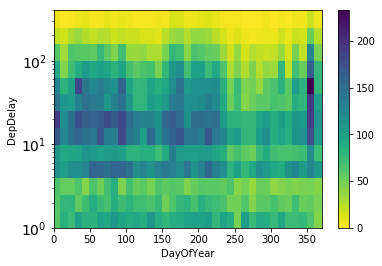

In [53]:
x = flights['DayOfYear']
y = flights['DepDelay']

x_min_val = 0
x_max_val = 366
x_binSize = 10
x_bin_edges = np.arange(x_min_val, x_max_val+x_binSize, x_binSize)

y_min_val = 0
y_max_val = 300
y_logBinSize = 0.2
y_bin_edges = 10 ** np.arange(y_min_val, np.log10(y_max_val)+y_logBinSize, y_logBinSize)

counts, _, _ = np.histogram2d(x, y, bins=(x_bin_edges, y_bin_edges))

fig, ax = plt.subplots()
plt.pcolormesh(x_bin_edges, y_bin_edges, counts.T, cmap = 'viridis_r')
tick_locs = [1, 10, 100]
#tick_locs = [0, 1, 3, 10, 30, 100, 300]
labels = ['{}'.format(v) for v in tick_locs]
plt.ylabel('DepDelay')
plt.xlabel('DayOfYear')
plt.yticks(tick_locs, labels, fontsize=14)

ax.figure.axes[-1].set_yscale('log')
plt.colorbar()
plt.show()

**Observations:**
* Departure delays seem to follow the same general trends as arrival delays with respect to time of year

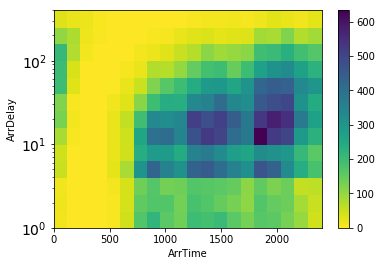

In [54]:
x = flights['ArrTime']
y = flights['ArrDelay']

x_min_val = 0
x_max_val = 2400
x_binSize = 120
x_bin_edges = np.arange(x_min_val, x_max_val+x_binSize, x_binSize)

y_min_val = 0
y_max_val = 300
y_logBinSize = 0.2
y_bin_edges = 10 ** np.arange(y_min_val, np.log10(y_max_val)+y_logBinSize, y_logBinSize)

counts, _, _ = np.histogram2d(x, y, bins=(x_bin_edges, y_bin_edges))

fig, ax = plt.subplots()
plt.pcolormesh(x_bin_edges, y_bin_edges, counts.T, cmap = 'viridis_r')
tick_locs = [1, 10, 100]
#tick_locs = [0, 1, 3, 10, 30, 100, 300]
labels = ['{}'.format(v) for v in tick_locs]
plt.ylabel('ArrDelay')
plt.xlabel('ArrTime')
plt.yticks(tick_locs, labels, fontsize=14)

ax.figure.axes[-1].set_yscale('log')
plt.colorbar()
plt.show()

**Observations:**
* Arrival delays seem to be the worst in the mid-afternoon (~2:00pm) and in the evening (~10:00pm)

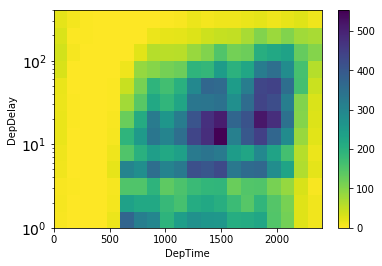

In [55]:
x = flights['DepTime']
y = flights['DepDelay']

x_min_val = 0
x_max_val = 2400
x_binSize = 120
x_bin_edges = np.arange(x_min_val, x_max_val+x_binSize, x_binSize)

y_min_val = 0
y_max_val = 300
y_logBinSize = 0.2
y_bin_edges = 10 ** np.arange(y_min_val, np.log10(y_max_val)+y_logBinSize, y_logBinSize)

counts, _, _ = np.histogram2d(x, y, bins=(x_bin_edges, y_bin_edges))

fig, ax = plt.subplots()
plt.pcolormesh(x_bin_edges, y_bin_edges, counts.T, cmap = 'viridis_r')
tick_locs = [1, 10, 100]
#tick_locs = [0, 1, 3, 10, 30, 100, 300]
labels = ['{}'.format(v) for v in tick_locs]
plt.ylabel('DepDelay')
plt.xlabel('DepTime')
plt.yticks(tick_locs, labels, fontsize=14)

ax.figure.axes[-1].set_yscale('log')
plt.colorbar()
plt.show()

**Observations:**
* Arrival delays seem to be the worst in the mid-afternoon (~2:00pm)

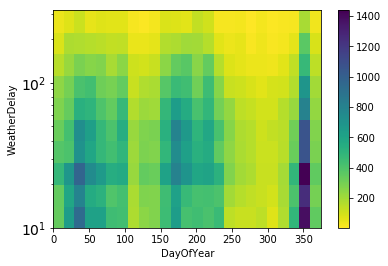

In [56]:
x = flights_all['DayOfYear']
y = flights_all['WeatherDelay']

x_min_val = 0
x_max_val = 366
x_binSize = 15
x_bin_edges = np.arange(x_min_val, x_max_val+x_binSize, x_binSize)

y_min_val = 1
y_max_val = 300
y_logBinSize = 0.15
y_bin_edges = 10 ** np.arange(y_min_val, np.log10(y_max_val)+y_logBinSize, y_logBinSize)

counts, _, _ = np.histogram2d(x, y, bins=(x_bin_edges, y_bin_edges))

fig, ax = plt.subplots()
plt.pcolormesh(x_bin_edges, y_bin_edges, counts.T, cmap = 'viridis_r')
tick_locs = [1, 10, 100]
#tick_locs = [0, 1, 3, 10, 30, 100, 300]
labels = ['{}'.format(v) for v in tick_locs]
plt.ylabel('WeatherDelay')
plt.xlabel('DayOfYear')
plt.yticks(tick_locs, labels, fontsize=14)

ax.figure.axes[-1].set_yscale('log')
plt.colorbar()
plt.show()

**Observations:**
* Weather delays seem to be the worst during the holidays (go figure)
* However, weather delays also seem to spike in Feburary and in the summer
  * This is probably due to late winter and early-summer storms
<br><br>

**Here is a more legible version of this particular chart (WeatherDelay 2D Histogram) for potential inclusion in the final report:**

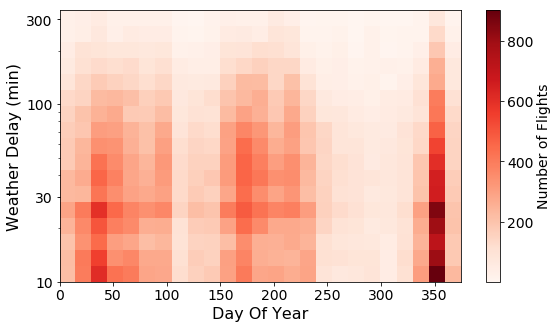

In [57]:
x = flights_all['DayOfYear']
y = flights_all['WeatherDelay']

x_min_val = 0
x_max_val = 366
x_binSize = 15
x_bin_edges = np.arange(x_min_val, x_max_val+x_binSize, x_binSize)

y_min_val = 1
y_max_val = 300
y_logBinSize = 0.09
y_bin_edges = 10 ** np.arange(y_min_val, np.log10(y_max_val)+y_logBinSize, y_logBinSize)

counts, _, _ = np.histogram2d(x, y, bins=(x_bin_edges, y_bin_edges))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9,5])
plt.pcolormesh(x_bin_edges, y_bin_edges, counts.T, cmap = 'Reds')
tick_locs = [10, 30, 100, 300]
labels = ['{}'.format(v) for v in tick_locs]
plt.ylabel('Weather Delay (min)', fontsize=16)
plt.xlabel('Day Of Year', fontsize=16)
plt.xticks(fontsize=14)

ax.figure.axes[-1].set_yscale('log')
plt.yticks(tick_locs, labels, fontsize=14)
#axis.set_major_formatter(ScalarFormatter())
plt.colorbar()
ax.figure.axes[-1].tick_params(labelsize=14)
ax.figure.axes[-1].set_ylabel('Number of Flights', size=14)
#title_string=('Number of Flights')
#plt.suptitle(title_string, x=0.45, y=0.97, fontsize=18)
plt.show()

**Observations:**
* Weather delays seem to be the worst during the holidays (go figure)
* However, weather delays also seem to spike in Feburary and in the summer
  * This is probably due to late winter and early-summer storms

<a id='bivariate_exploration_summary'></a>
([Top of Page](#top_of_page))
## Bivariate Exploration - Summary

<a id='bivariate_exploration_relationships_observed'></a>
([Top of Page](#top_of_page))
### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
**Observations (largely repeated from prior comments):**

* Regarding which variables affect Arrival and Departure Delay:
  * **'SecurityDelay'** does not correlate to any other variables. It should be removed from consideration
  * **'ActualElaspedTime', 'CRSElapsedTime', 'AirTime',** and **'Distance'** are only significantly correlated with one another. They should be removed from consideration.

  * When zero values are removed, **'ArrDelay'** and **'DepDelay'** are most strongly correlated with **'CarrierDelay'**, **'WeatherDelay'**, and **'LateAircraftDelay'**
  * Removing zeros from delay variables casuses **'WeatherDelay'** to be more strongly correlated with **'ArrDelay'** and **'DepDelay'** than **'NASDelay'**
    * This implies that Weather Delays happen less often than NAS Delays, but have a larger impact on arrival and departure delays<br>


* Airports:
  * ORD and SFO airports are capable of higher arrival delays (75% quartile values) than other top 10 destinations
  * ORD, DFW, and SFO are capable of higher departure delays (75% quartile values) than other top 10 origins
<br><br>

* Airlines:
  * UA, AA, MQ, and CO are capable of higher arrival delays (75% quartile values) than other top 10 airlines
  * US has the lowest median arrival delay
  * UA and AA are capable of higher departure delays (75% quartile values) than other top 10 airlines
  * WN has the one of the lowest median arrival delays, but also has highest median departure delay. That is an interesting juxtaposition
<br><br>

* General observation:
  * Box plots were more intuitive than violin plots for assessing the differences in the distributions 

<a id='bivariate_exploration_relationships_observed_unexpected'></a>
([Top of Page](#top_of_page))
### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?



* I was surprised that **'DepTime'** did not have a stronger correlation with **'ArrTime'** 
  * the correlation between the two was ~0.71
  * Yes, delays clearly exist, but I would have thought that those two parameters would have a correlation of 0.9 or higher
  * a similar situation existed for scheduled departure time (**'CRSDepTime'**) and scheduled arrival time (**'CRSArrTime'**)
* **'NASDelay'** had weak correlations with almost everything, but its strongest correlation (~0.5) was with **'TaxiOut'**.
  * Since I had never heard of NAS delays prior to this project, I found it interesting that some baic analysis indicates roughly when NAS Delays occur within the flight timeline
* I was surprised to see not just one mode to the WeatherDelay vs Time distribution, but three (Christmas, February, and early summer)
  * This implies that one can get a sense of when large storms hit the United States by looking at flight history data

<a id='multivariate_exploration'></a>
([Top of Page](#top_of_page))
## Multivariate Exploration
<br>

* **To focus the multivariate analysis, I am only going to assess Arrival and Departure Delays against the following airports / airlines:**
  * airports:  ORD, DFW, and SFO
  * airlines:  UA, AA, and US
  * This is based on those airports and airlines being among the [top 10 most frequented](#univariate_otherVar_categorical) and among those with the [largest delays](#bivariate_exploration_boxPlot_observations)
<br><br>

* **I will also check to see how 'WeatherDelay' affects arrival and departure delays**
  * Since **'WeatherDelay'** delays happen less often than other delay types, and since a non-zero **'WeatherDelay'** has a strong correlation to **'ArrDelay'** and **'DepDelay'**, I suspect **'WeatherDelay'** is a significant swing factor affecting Arrival and Departure delays
<br><br>
  
* **I plan to start by:**
  * Creating scatter plots of arrival / departure delays vs day of year and coloring the data by WeatherDelay

<a id='multivariate_scatter'></a>
([Top of Page](#top_of_page))
### Colored Scatter Plots

* Create scatter plots of arrival / departure delays vs day of year
* Color the data by **'WeatherDelay'**
* Since there are a lot of zero or NaN values for **'WeatherDelay'**, only look at flights where there was a non-zero value for **'WeatherDelay'**
  * Start by plotting all such flights in 2008 (dataframe **'flights_all'**)

In [58]:
mask1 = flights_all['WeatherDelay'] > 0
flights_weather = flights_all[mask1]
flights_weather.ArrDelay.describe()

count    99985.000000
mean        84.184158
std         74.639632
min         15.000000
25%         35.000000
50%         62.000000
75%        109.000000
max       1417.000000
Name: ArrDelay, dtype: float64

In [59]:
flights_weather.ArrDelay.median()

62.0

In [60]:
mask1 = flights['LateAircraftDelay'] > 0
flights_lateAC = flights[mask1]
#flights_lateAC.ArrDelay.describe()

In [61]:
mask1 = flights['CarrierDelay'] > 0
flights_carrier = flights[mask1]
#flights_carrier.ArrDelay.describe()

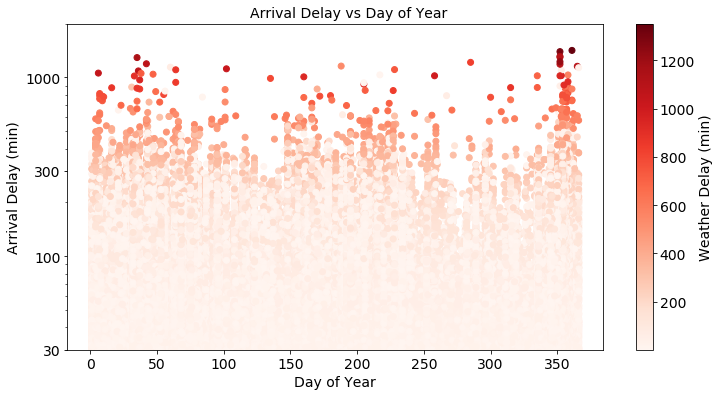

In [62]:
plt.figure(figsize = [12, 6])
ax = plt.scatter(data = flights_weather, x='DayOfYear', y='ArrDelay', alpha=1, cmap='Reds', c='WeatherDelay');
plt.xlabel('Day of Year', fontsize=14)
plt.ylabel('Arrival Delay (min)', fontsize=14)
plt.yscale('log')
tick_locs = [100, 200, 300, 500, 1000, 2000]
tick_locs = [30, 100, 300, 1000]
plt.yticks(tick_locs, tick_locs, fontsize=14)
plt.xticks(fontsize=14)
plt.ylim(30, 2000)
plt.colorbar()
ax.figure.axes[-1].tick_params(labelsize=14)
ax.figure.axes[-1].set_ylabel('Weather Delay (min)', size=14)
title_string=('Arrival Delay vs Day of Year')
plt.suptitle(title_string, x=0.45, y=0.92, fontsize=14)
plt.show()

**Observations:**
* Ok, that chart suffers from overplotting. Let's look at the smaller dataframe **'flights'** to see if trends become a little more clear.
* Let's also write a function to speed this up

**Function to create colored scatter plots:**

In [63]:
def plot_color_scatter(df, varX, varY, varColor, titleX, titleY, titleFig, titleColor):
    plt.figure(figsize = [9, 4])
    ax = plt.scatter(data = df, x=varX, y=varY, alpha=1, cmap='Reds', c=varColor);
    plt.xlabel(titleX, fontsize=12)
    plt.ylabel(titleY, fontsize=12)
    plt.yscale('log')
    tick_locs = [100, 200, 300, 500, 1000, 2000]
    plt.yticks(tick_locs, tick_locs, fontsize=12)
    plt.xticks(fontsize=14)
    plt.ylim(100, 2000)
    plt.colorbar()
    ax.figure.axes[-1].tick_params(labelsize=12)
    ax.figure.axes[-1].set_ylabel(titleColor, size=12)
    plt.suptitle(titleFig, x=0.45, y=0.86, fontsize=12)
    plt.show()

The same chart as before, but with a smaller data set and modified y-axis:

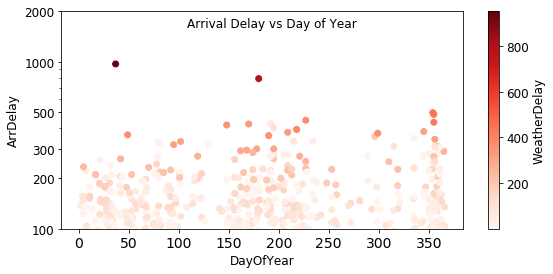

In [64]:
varX = 'DayOfYear'
varY = 'ArrDelay'
varColor = 'WeatherDelay'

df_to_plot = flights[(flights[varColor] > 0)]
titleFig=('Arrival Delay vs Day of Year')
plot_color_scatter(df_to_plot, varX, varY, varColor, varX, varY, titleFig, varColor)

**Observations:**
* This chart is much more intuitive than the previous one.
* Long Weather delays and arrival delays appear to be more likely in the winter as shown by the number of darker red points in the first part of the year and near the end of the year
* There also seems to be some possibility for long weather delays in the early summer.
* This corresponds to trends observed in the 2D histograms, where I noted: _"I was surprised to see not just one mode to the WeatherDelay vs Time distribution, but three (Christmas, February, and early summer)"_
  * This increases my confidence that the (somewhat) tri-modal characteristic of weather delays is real

**Next steps:**
* I plan to look at the interaction between the above variables (**'ArrDelay'**, **'WeatherDelay'**, and **'DayOfYear'**) with airports and airlines (**'Origin'**, **'Dest'**, **'UniqueCarrier'**)

**Create colored scatter plots for flights with a destination of ORD, SFO, or DFW:**
* Since these will be filtered by destination, **'ArrDelay'** is more pertinent than **'DepDelay'** as a y-axis
* Since filtering for destination inherently reduces the data set, start with the larger dataframe (**'flights_all'**) and filter from there

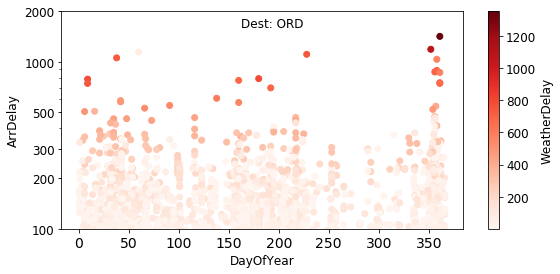

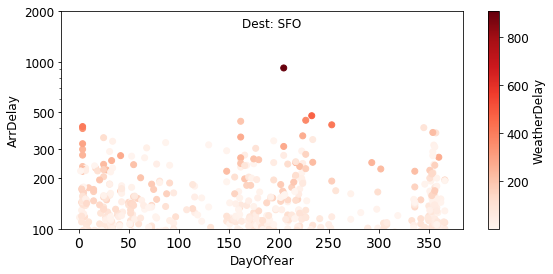

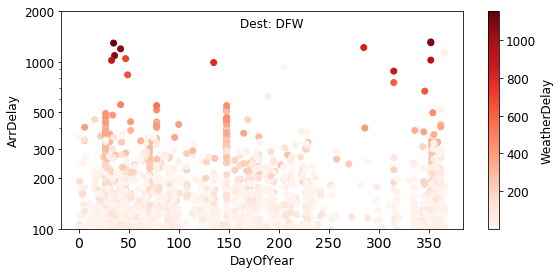

In [65]:
varX = 'DayOfYear'
varY = 'ArrDelay'
varColor = 'WeatherDelay'
varFilt = 'Dest'
valuesFilt = ['ORD', 'SFO', 'DFW']
for i in range(len(valuesFilt)):
    df_to_plot = flights_all[(flights_all[varColor] > 0) & (flights_all[varFilt] == valuesFilt[i])]
    titleFig = (varFilt + ': ' + valuesFilt[i])
    plot_color_scatter(df_to_plot, varX, varY, varColor, varX, varY, titleFig, varColor)

**Repeat, but this time for Origins and Departure Delays:**

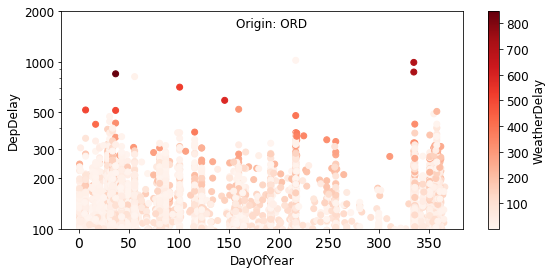

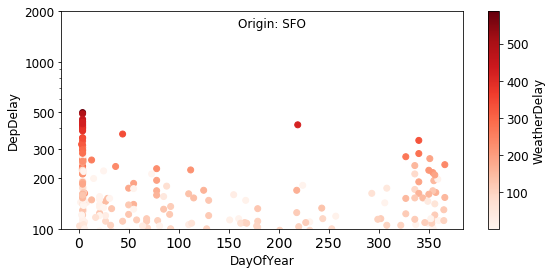

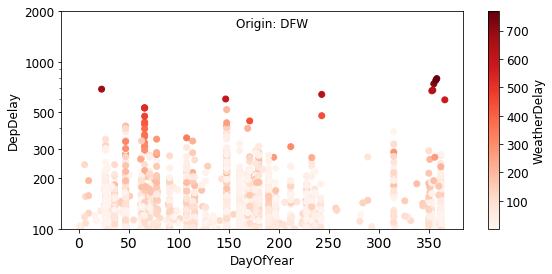

In [66]:
varX = 'DayOfYear'
varY = 'DepDelay'
varColor = 'WeatherDelay'
varFilt = 'Origin'
valuesFilt = ['ORD', 'SFO', 'DFW']
for i in range(len(valuesFilt)):
    df_to_plot = flights_all[(flights_all[varColor] > 0) & (flights_all[varFilt] == valuesFilt[i])]
    titleFig = (varFilt + ': ' + valuesFilt[i])
    plot_color_scatter(df_to_plot, varX, varY, varColor, varX, varY, titleFig, varColor)

**'Observations':**
* ORD has a fairly consistent amount of long delays throughout the year (compared to the other airports)
* Delays for all airports increased during the holidays
* SFO and DFW both tend to have long delays during specific periods of the year
* SFO appeared to have some sort of weather event at the beginning of 2008

**Now, let's repeat both sets of charts, but this time filtering by some of the top airlines (UA, AA, and US)**

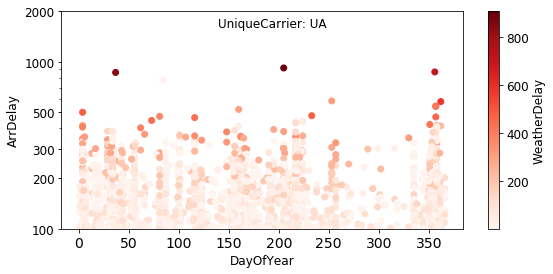

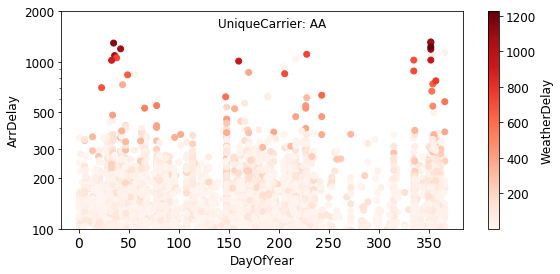

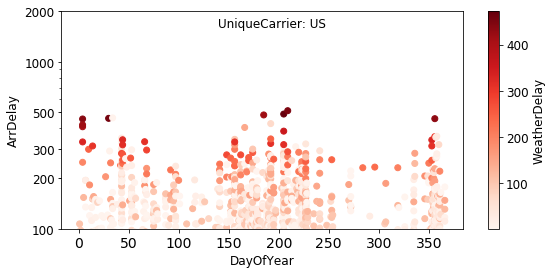

In [67]:
varX = 'DayOfYear'
varY = 'ArrDelay'
varColor = 'WeatherDelay'
varFilt = 'UniqueCarrier'
valuesFilt = ['UA', 'AA', 'US']
for i in range(len(valuesFilt)):
    df_to_plot = flights_all[(flights_all[varColor] > 0) & (flights_all[varFilt] == valuesFilt[i])]
    titleFig = (varFilt + ': ' + valuesFilt[i])
    plot_color_scatter(df_to_plot, varX, varY, varColor, varX, varY, titleFig, varColor)

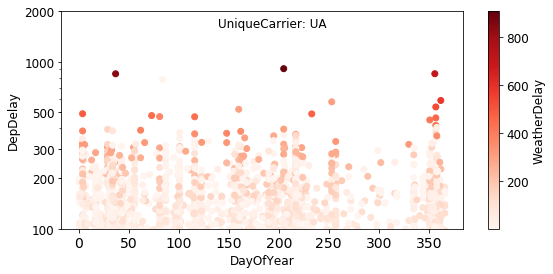

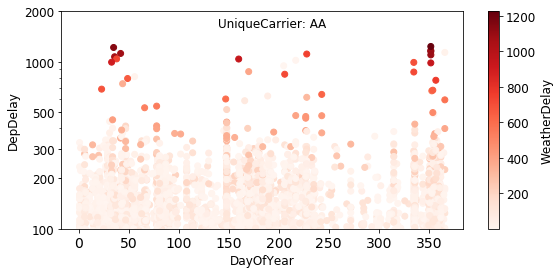

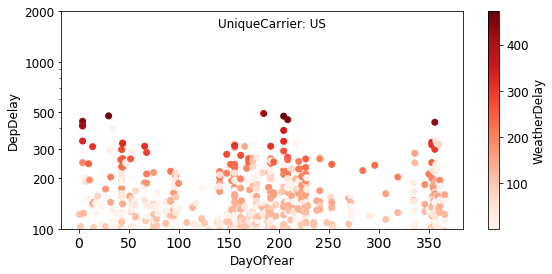

In [68]:
varX = 'DayOfYear'
varY = 'DepDelay'
varColor = 'WeatherDelay'
varFilt = 'UniqueCarrier'
valuesFilt = ['UA', 'AA', 'US']
for i in range(len(valuesFilt)):
    df_to_plot = flights_all[(flights_all[varColor] > 0) & (flights_all[varFilt] == valuesFilt[i])]
    titleFig = (varFilt + ': ' + valuesFilt[i])
    plot_color_scatter(df_to_plot, varX, varY, varColor, varX, varY, titleFig, varColor)

**Observations:**
* American Airlines (AA) has some noticeable spikes in weather-related delays during the winter and a couple such delays in the summer
* during the winter, United Airlines (UA) also has some increases in weather-related departure delays, but not nearly as many
* United Airlines is less likely than American Airlines  to have weather cause an increase in departure or arrival delays
* US Airways (UA) is susceptible to weather-related delays in the summer, however they tend to have shorter delays than the other airlines.
* Some of this is [confirmation of what the box plots previously indicated](#bivariate_exploration_boxPlot_observations)
* A potential complicating factor is that some airlines may be more of a "regional carrier" than other airlines
<br>

**Next Steps:**
* Let's look at a "calendar plot" of delays for various airports to see if that provides any additional insight

<a id='multivariate_calendar'></a>
([Top of Page](#top_of_page))
### Calendar Plots

<a id='multivariate_calendar_setup'></a>
([Top of Page](#top_of_page))
#### Setting up the Calendar Plots
<br>

Start by writing a function that reduces a dataframe to its median delay values:

In [69]:
# group a df by the column 'varGroupBy', collect medians, only keep 'varsKeep' columns, then reshape the df
'''
    - assumes that elements of varskeep are as follows:
        - 0th element: variable to groupby   /  pivoting: values
        - 1st element: 'Week' variable       /  pivoting: index
        - 2nd element: 'DayOfWeek' variable  /  pivoting: columns
'''
def reduce_df_median(data, varGroupBy, varsKeep):
    # reduce the dataframe
    data_new = data.groupby(varGroupBy).median()
    data_new = data_new[varsKeep]
    
    # convert data type to int
    data_new['Week'] = data_new['Week'].astype(np.int64)
    data_new['DayOfWeek'] = data_new['DayOfWeek'].astype(np.int64)
    
    # reshape the dataframe
    data_new = pd.pivot_table(data_new, values = varsKeep[0], index=[varsKeep[1]], columns = varsKeep[2])
    
    return data_new

Using the above function, create two "calendar" data frames, one for arrival delays, and one for departure delays

In [70]:
flights_days_Arr = reduce_df_median(flights, 'DayOfYear', ['ArrDelay', 'DayOfWeek', 'Week'])
flights_days_Dep = reduce_df_median(flights, 'DayOfYear', ['DepDelay', 'DayOfWeek', 'Week'])

In [71]:
flights_days_Arr.head(10)

Week         1    2    3    4     5    6    7     8    9     10  ...   44  \
DayOfWeek                                                        ...        
1           NaN -3.0 -5.0  7.0  -1.0  6.0 -1.0   3.5 -1.0   1.0  ... -1.0   
2           6.0 -1.0 -5.0  4.0   0.0  1.0  3.0   0.0  6.0   2.0  ... -3.5   
3          10.0 -4.0 -5.0 -2.0  -3.0  2.0  5.0  -3.0 -1.0  -1.0  ... -7.0   
4           5.0 -3.0  4.0 -1.0   4.0  1.0  2.0   3.0 -3.0  -3.0  ... -5.0   
5           1.0 -2.0  3.0  0.0  11.0  1.0  1.0  11.0  3.0  11.0  ... -8.0   
6           3.0 -7.0 -3.0 -1.0  -2.0 -5.0 -2.0   1.0 -3.0   9.5  ... -8.5   
7           1.0 -3.5 -3.0  2.0   1.0  1.0  5.0  -1.0 -3.0   2.0  ... -5.0   

Week        45   46   47    48    49   50    51    52   53  
DayOfWeek                                                   
1         -5.0 -7.0 -6.0  -4.0  14.0 -5.5   7.0  13.0 -4.0  
2         -7.0 -5.0 -7.0  -5.0  -1.0 -1.5   9.0  14.0 -2.0  
3         -7.0 -3.0 -5.0  -4.0  -3.0 -1.0  14.0  11.0  0.0  
4         -5.0 -2.0 -5.0  -8.0  -2.0  0.0  10.0  -5.0  NaN  
5         -0.5  0.0  0.0  -7.0  -5.0  1.0  15.0   7.5  NaN  
6         -7.0 -7.0 -7.0  -3.5  -5.0 -5.0  18.5  13.5  NaN  
7         -6.0 -4.0 -7.0  17.0  -2.5  0.0  20.0   1.0  NaN  

[7 rows x 53 columns]

The subsequent plots will not plot the NaN values, but that is appropriate since they just reflect the particular calendar for 2008

In [72]:
# will be used to keep vmin and vmax values consistent across calendar plots
minArrDelay_median = flights_days_Arr.min().sort_values(ascending=True).iloc[0]
maxArrDelay_median = flights_days_Arr.max().sort_values(ascending=False).iloc[0]
minDepDelay_median = flights_days_Dep.min().sort_values(ascending=True).iloc[0]
maxDepDelay_median = flights_days_Dep.max().sort_values(ascending=False).iloc[0]

print(minArrDelay_median)
print(maxArrDelay_median)
print(minDepDelay_median)
print(maxDepDelay_median)

-9.5
20.0
-4.0
15.0


**Create a "calendar plot" of median arrival delay (color) vs day of the week (y-axis) vs day of the year (x-axis)**

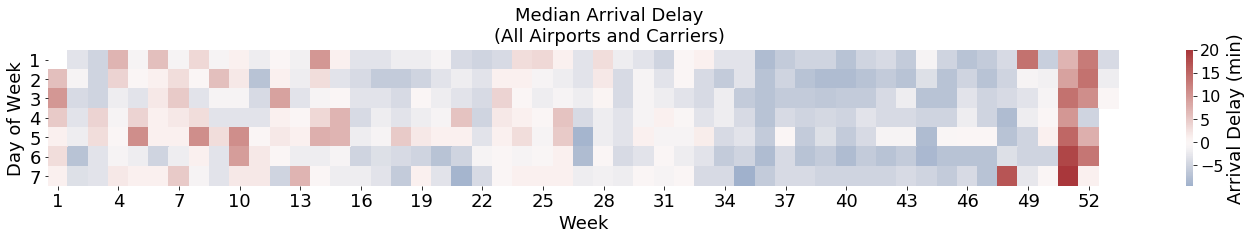

In [73]:
plt.figure(figsize = [24, 2.5])
ax = sb.heatmap(flights_days_Arr, cmap = 'vlag', center = 0, cbar=True, xticklabels=3, 
                vmin = minArrDelay_median, vmax = maxArrDelay_median)
plt.xlabel('Week', fontsize=18)
plt.ylabel('Day of Week', fontsize=18)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(rotation=0, ha='right', fontsize=18)
ax.figure.axes[-1].tick_params(labelsize=16)
ax.figure.axes[-1].set_ylabel('Arrival Delay (min)', size=18)       
title_string=('Median Arrival Delay\n(All Airports and Carriers)')
plt.suptitle(title_string, x=0.45, y=1.12, fontsize=18)
plt.show()

**Repeat for Departure delays**

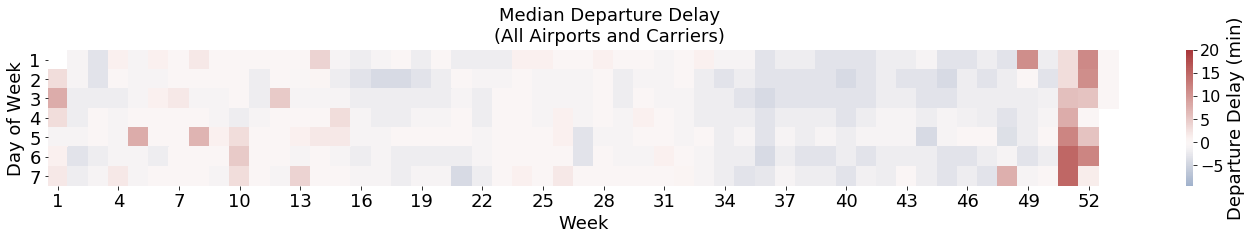

In [74]:
# used to keep vmin and vmax values consistent across calendar plots
minArrDelay_median = flights_days_Arr.min().sort_values(ascending=True).iloc[0]
maxArrDelay_median = flights_days_Arr.max().sort_values(ascending=False).iloc[0]

plt.figure(figsize = [24, 2.5])
ax = sb.heatmap(flights_days_Dep, cmap = 'vlag', center = 0, cbar=True, xticklabels=3, 
                vmin = minArrDelay_median, vmax = maxArrDelay_median)
plt.xlabel('Week', fontsize=18)
plt.ylabel('Day of Week', fontsize=18)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(rotation=0, ha='right', fontsize=18)
ax.figure.axes[-1].tick_params(labelsize=16)
ax.figure.axes[-1].set_ylabel('Departure Delay (min)', size=18)       
title_string=('Median Departure Delay\n(All Airports and Carriers)')
plt.suptitle(title_string, x=0.45, y=1.12, fontsize=18)
plt.show()

**Observations:**
* Both arrival and departure delays increase during the holidays
* There are a number of isolated increases in delays during the winter. These are likely weather-related events.
* Arrival delays tend to be larger than depature delays, as indicated by the lack of color in the departure plot
* Week 14 is interesting, in that there is a spike of delays on the Monday and Friday of that week. I suspect this may have been the peak spring break week in 2008.

**Next Steps:**
* Write some functions to speed up future such plots
* Look at how the calendar plots change based on airport and airline

**A function to create a calendar plot:**

In [75]:
def plotCal(df, mask, delayType):
    df_new = df[mask]
    df_reduced = reduce_df_median(df_new, 'DayOfYear', [delayType, 'DayOfWeek', 'Week'])

    # "calendar matrix" of flights with the given mask
    plt.figure(figsize = [24, 2.5])
    ax = sb.heatmap(df_reduced, cmap = 'vlag', center = 0, cbar=True, xticklabels=3)
    plt.xlabel('Week', fontsize=18)
    plt.ylabel('Day of Week', fontsize=18)
    plt.xticks(rotation=0, fontsize=18)
    plt.yticks(rotation=0, ha='right', fontsize=18)
    ax.figure.axes[-1].tick_params(labelsize=14)
    if delayType == 'ArrDelay':
        ax.figure.axes[-1].set_ylabel('Arrival Delay (min)', size=18)
        title_string=('Median Arrival Delay')
    else:
        ax.figure.axes[-1].set_ylabel('Departure Delay (min)', size=18)
        title_string=('Median Departure Delay')
    plt.suptitle(title_string, x=0.45, y=1.04, fontsize=18)
    plt.show()

**Function to create a calendar plot with a specific vmin and vmax:**

In [76]:
def plotCal_specific_cBar(df, mask, delayType, cBarMin, cBarMax):
    df_new = df[mask]
    df_reduced = reduce_df_median(df_new, 'DayOfYear', [delayType, 'DayOfWeek', 'Week'])

    # "calendar matrix" of flights with the given mask
    plt.figure(figsize = [24, 2.5])
    ax = sb.heatmap(df_reduced, cmap = 'vlag', center = 0, cbar=True, xticklabels=3, vmin=cBarMin, vmax=cBarMax)
    plt.xlabel('Week', fontsize=18)
    plt.ylabel('Day of Week', fontsize=18)
    plt.xticks(rotation=0, fontsize=18)
    plt.yticks(rotation=0, ha='right', fontsize=18)
    ax.figure.axes[-1].tick_params(labelsize=14)
    if delayType == 'ArrDelay':
        ax.figure.axes[-1].set_ylabel('Arrival Delay (min)', size=18)
        title_string=('Median Arrival Delay')
    else:
        ax.figure.axes[-1].set_ylabel('Departure Delay (min)', size=18)
        title_string=('Median Departure Delay')
    plt.suptitle(title_string, x=0.45, y=1.04, fontsize=18)
    plt.show()

**Function to plot Arrival and Departure delays for a given airport:**

In [77]:
def plotCal_Airport(df, airport):
    
    # retrieve the median arrival delays for flights with <airport> as a destination
    mask = flights_all['Dest'] == airport             # select flights with a given mask
    df_new = df[mask]
    df_reduced_arr = reduce_df_median(df_new, 'DayOfYear', ['ArrDelay', 'DayOfWeek', 'Week'])
    
    # retrieve the median departure delays for flights with <airport> as an origin
    mask = flights_all['Origin'] == airport             # select flights with a given mask
    df_new = df[mask]
    df_reduced_dep = reduce_df_median(df_new, 'DayOfYear', ['DepDelay', 'DayOfWeek', 'Week'])
    
    # determine cBarMin and cBarMax
    minArr = df_reduced_arr.min().sort_values(ascending=True).iloc[0]
    maxArr = df_reduced_arr.max().sort_values(ascending=False).iloc[0]
    minDep = df_reduced_dep.min().sort_values(ascending=True).iloc[0]
    maxDep = df_reduced_dep.max().sort_values(ascending=False).iloc[0]
    cBarMin = min(minArr, minDep)
    cBarMax = max(maxArr, maxDep)
    
    plotCal_specific_cBar(df, flights_all['Dest'] == airport, 'ArrDelay', cBarMin, cBarMax)
    plotCal_specific_cBar(df, flights_all['Origin'] == airport, 'DepDelay', cBarMin, cBarMax)

**Function to plot Arrival and Departure delays for a given airline:**

In [78]:
def plotCal_Airline(df, airline):
    
    # retrieve the median arrival delays for flights with the given airline
    mask = flights_all['UniqueCarrier'] == airline             # select flights with a given mask
    df_new = df[mask]
    df_reduced_arr = reduce_df_median(df_new, 'DayOfYear', ['ArrDelay', 'DayOfWeek', 'Week'])
    
    # retrieve the median departure delays for flights with the given airline
    df_reduced_dep = reduce_df_median(df_new, 'DayOfYear', ['DepDelay', 'DayOfWeek', 'Week'])
    
    # determine cBarMin and cBarMax
    minArr = df_reduced_arr.min().sort_values(ascending=True).iloc[0]
    maxArr = df_reduced_arr.max().sort_values(ascending=False).iloc[0]
    minDep = df_reduced_dep.min().sort_values(ascending=True).iloc[0]
    maxDep = df_reduced_dep.max().sort_values(ascending=False).iloc[0]
    cBarMin = min(minArr, minDep)
    cBarMax = max(maxArr, maxDep)
    
    plotCal_specific_cBar(df, flights_all['UniqueCarrier'] == airline, 'ArrDelay', cBarMin, cBarMax)
    plotCal_specific_cBar(df, flights_all['UniqueCarrier'] == airline, 'DepDelay', cBarMin, cBarMax)

<a id='multivariate_calendar_delays_by_airport'></a>
([Top of Page](#top_of_page))
### Delays by Airport

**Arrival and Departure delays for 'ORD':**

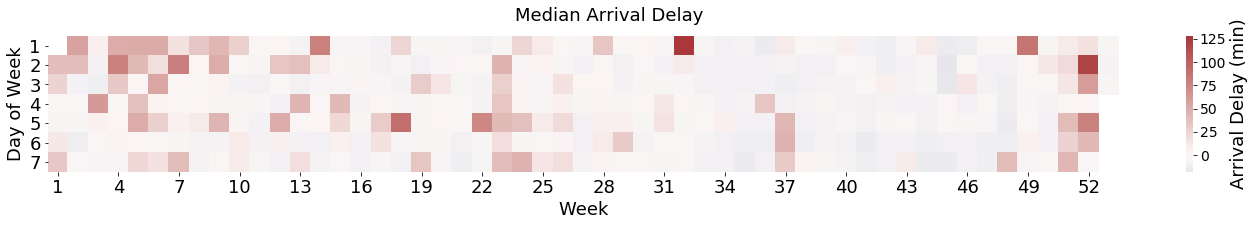

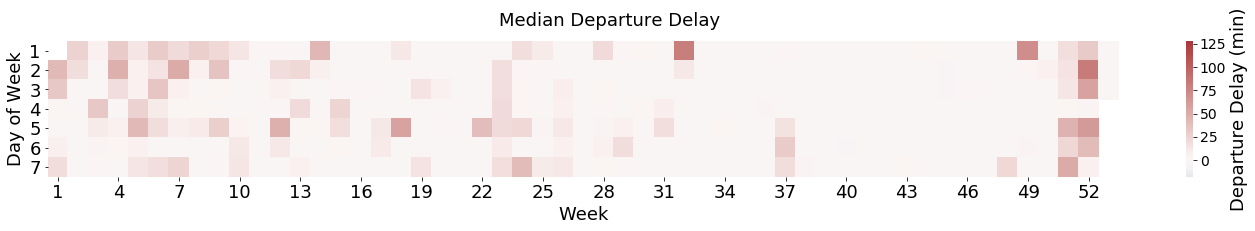

In [79]:
plotCal_Airport(flights_all, 'ORD')    # plot the calendar matrix

**Arrival and Departure delays for 'SFO':**

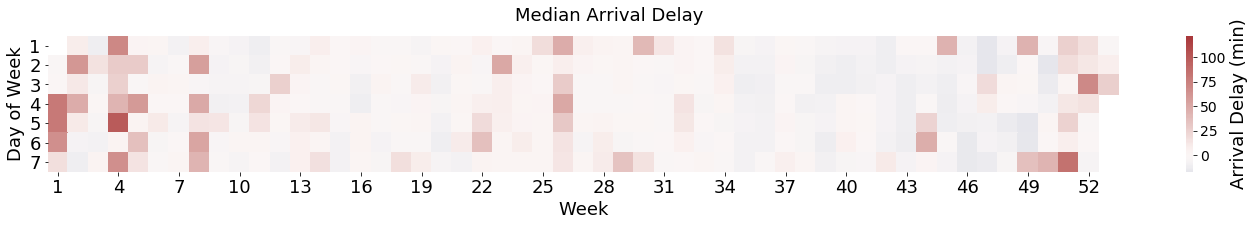

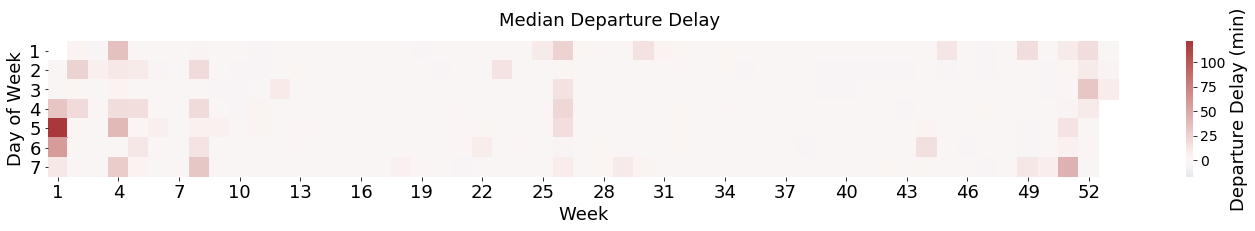

In [80]:
plotCal_Airport(flights_all, 'SFO')    # plot the calendar matrix

**Arrival and Departure delays for 'DFW':**

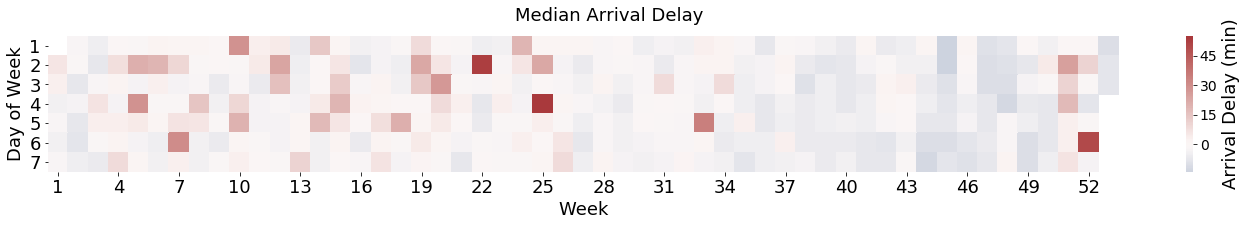

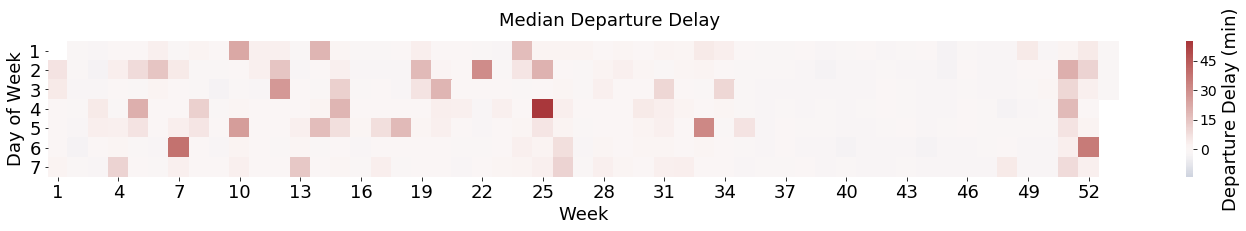

In [81]:
plotCal_Airport(flights_all, 'DFW')    # plot the calendar matrix

**Observations:**
* ORD has a string of arrival delays on Mondays in the beginning of the year. I suspect this represents a confluence of business travel and winter weather
* SFO had a particularly slow week at the beginning of the year. There appears to have been some sort of weather event, perhaps compounded by travelers returing home from an extended break.
* SFO has some other weeks in the first part of the year with long delays. It's possible that these are additional weather related delays
* DFW had some noteable single-day increases in delays during the middle of the year. I suspet these represent summer storms.

<a id='multivariate_calendar_delays_by_airline'></a>
([Top of Page](#top_of_page))
### Delays by Airline

**Arrival and Departure delays for 'UA':**

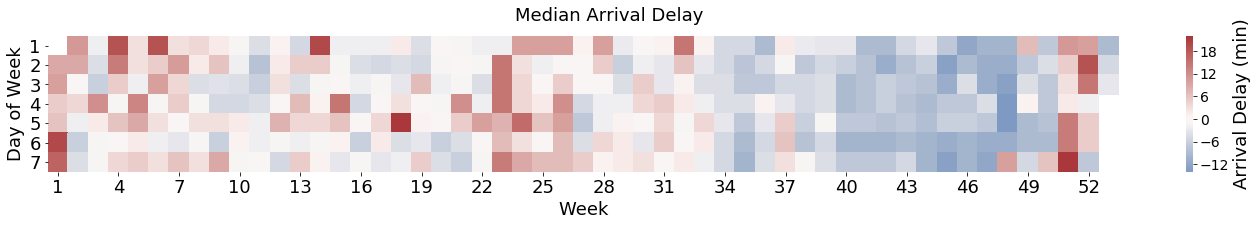

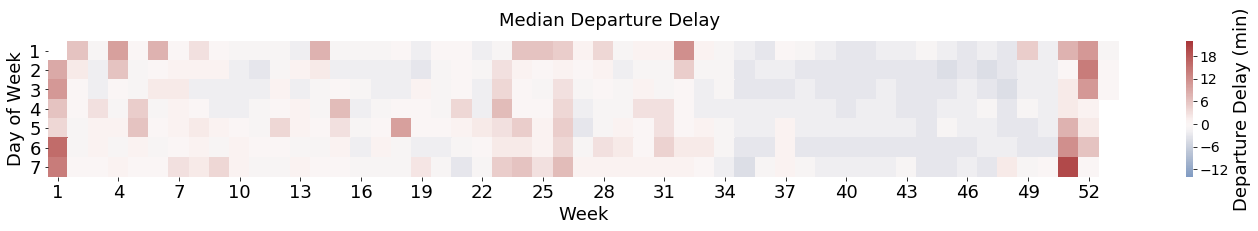

In [82]:
plotCal_Airline(flights_all, 'UA')    # plot the calendar matrix

**Arrival and Departure delays for 'AA':**

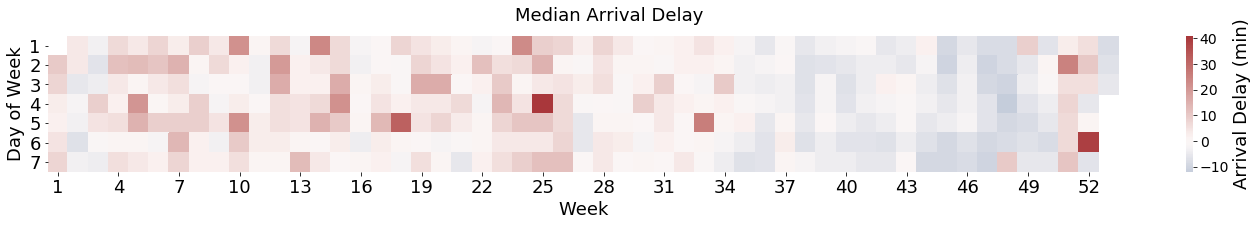

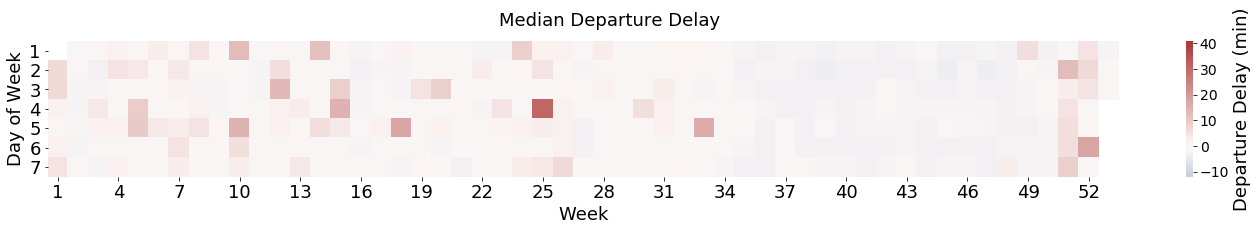

In [83]:
plotCal_Airline(flights_all, 'AA')    # plot the calendar matrix

**Arrival and Departure delays for 'US':**

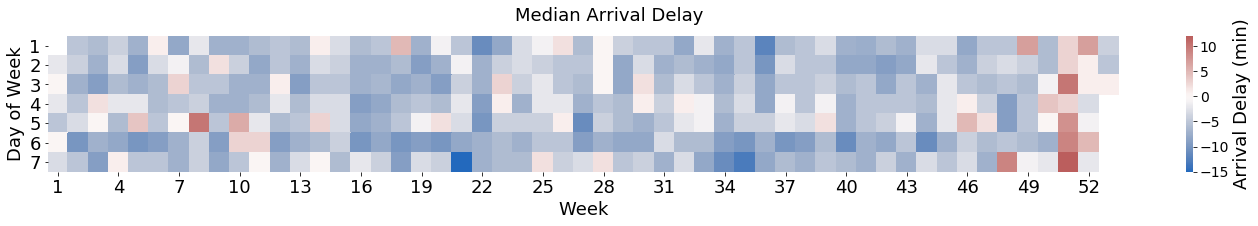

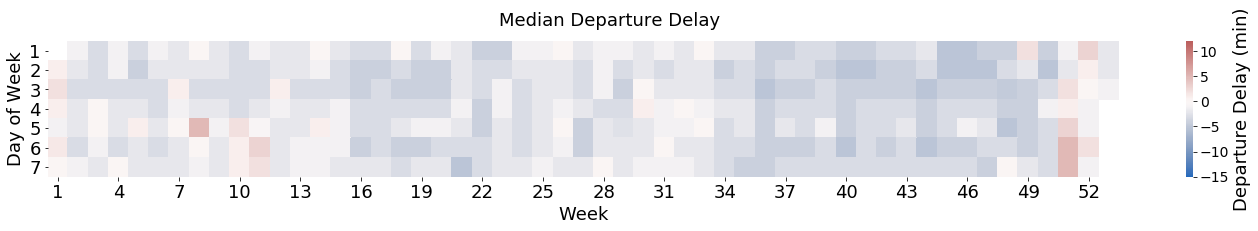

In [84]:
plotCal_Airline(flights_all, 'US')    # plot the calendar matrix

**Observations:**
* UA had several days with long delays earlier in the year, and a period in week 23 (June 2 - June 8) wherein the arrival delays rivaled those seen during the holidays.
  * I suspect the week 23 delays may have been due to end-of-school-year traffic and/or some sort of weather event.
* AA had some singularly long delays during the spring and summer
* US consistently had shorter delays than the other two airlines and often arrived early!
  * On-time performance does seem to be affected by which airline you choose

<a id='multivariate_exploration_summary'></a>
([Top of Page](#top_of_page))
## Multivariate Exploration - Summary

<a id='multivariate_exploration_relationships_observed'></a>
([Top of Page](#top_of_page))
### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

**Observations (largely repeated from prior comments):**

* As previously suspected, weather does seem to be a notable swing factor affecting the length of arrival and departure delays.
  * Confidence in this assessment was raised by looking at time-based plots for multiple airports and airlines
<br><br>

* There also appear to be unique cycles wherein a given airport and/or airline is likely to have longer delays.
  * Some airports, such as ORD, have a fairly consistent amount of long delays throughout the year
  * Other airports, such as DFW, tend to be much more cyclical with respect to long delays


* Weather and Time of year:
  * Delays for all airports increased during the holidays
  * Weather, depature, and arrival delays appear to be more likely in the winter
  * There also seems to be some possibility for long weather-related delays in the early summer
<br><br>

* Some airlines are less susceptible to weather-related delays
  * A potential complicating factor is that some airlines may be more of a "regional carrier" than other airlines
<br><br>

* If you wanted to have little to no delay in 2008, some good ways to attempt this would have been:
  * Fly in the fall (for most airports)
  * Fly on US Airways (at practically any time of the year)
<br><br>

* **Overall: time of year, weather, airport, and airline are significant factors that affect the likelihood of having a long or a short delay**

<a id='multivariate_exploration_relationships_observed_interesting_interactions'></a>
([Top of Page](#top_of_page))
### Were there any interesting or surprising interactions between features?

* Week 14 (March 31 - April 6) was interesting, in that there were a spike of delays on the Monday and Friday of that week. I suspect this may have been the peak spring break week in 2008.

* ORD had a string of arrival delays on Mondays in the beginning of the year. I suspect this may have been a confluence of business travel and winter weather

* UA had a period in week 23 (June 2 - June 8) wherein the arrival delays rivaled those seen during the holidays.
  * I suspect this may have been due to end-of-school-year traffic and/or some sort of weather event.

* US consistently had shorter delays than the other two airlines and often arrived early!
  * On-time performance does seem to be affected by which airline you choose

<a id='references'></a>
([Top of Page](#top_of_page))
## References
Some of the links served as style guides on how to perform a given operation. However, most of them have just been copied below because they seemed interesting and/or applicable to the types of analysis and plots herein.

* Here is a reference for [setting matplotlib title properties](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.set_title.html)

* Reference [for adding text to matplotlib plots](https://matplotlib.org/3.1.1/tutorials/text/text_intro.html)

* Reference for [adding a figure title and subplot titles](https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/figure_title.html)

* [Types of charts](https://about.infogr.am/wp-content/uploads/2016/01/types-of-charts.jpg) - graphic scheme

* A compilation of the ["Top 50 most useful" matplotlib plots in data analysis and visualization](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/)

* [Python Graph Gallery](https://python-graph-gallery.com), a site with hundreds of different chart types (and code samples) that can be created using Python
  * Python graph gallery - [list of possible seaborn plots](https://python-graph-gallery.com/category/seaborn/)
  * Python graph gallery - [list of possible matplotlib plots](https://python-graph-gallery.com/category/matplotlib/)
  
* List of [Seaborn color palettes](https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/)

* Matplotlib [documentation on chooosing colormaps](https://matplotlib.org/users/colormaps.html)
  * Blog post on choosing the wrong color map: ["How Bad Is Your Colormap?"](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/)
  * Blog post articulating ["How The Rainbow Color Map Misleads"](https://eagereyes.org/basics/rainbow-color-map)
  * [ColorBrewer](http://colorbrewer2.org/#type=sequential&scheme=Greys&n=3), a color map selection and advice tool

* Seaborn [heatmap documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

* Single Page ["cheat sheet" for plotting with Seaborn](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Seaborn_Cheat_Sheet.pdf)

* StackOverflow page describing [how to fix irregular spacing of xticklabels that have been rotated](https://stackoverflow.com/questions/21477465/matplotlib-python-barplot-position-of-xtick-labels-have-irregular-spaces-betwee)

* Matplotlib - [colorbar documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.colorbar.html)

* Matplotlib documentation: [some annotated heatmap examples](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

* StackOverflow page describing [how to modify colorbar properties](https://stackoverflow.com/questions/6567724/matplotlib-so-log-axis-only-has-minor-tick-mark-labels-at-specified-points-also/6568248#6568248) - references plots that are plotted using the  'Fig, ax' coding style

* StackOverflow example of how to [append the same string to a list of strings in Python](https://stackoverflow.com/questions/2050637/appending-the-same-string-to-a-list-of-strings-in-python):
  * <code>[s + mystring for s in mylist]</code>

* StackOverflow page on [how to convert multiple columns into one datetime column in pandas](https://stackoverflow.com/questions/19350806/how-to-convert-columns-into-one-datetime-column-in-pandas/37103131)

* Interesting StackOverflow [example of creating a calendar heatmap _without_ Pandas](https://stackoverflow.com/questions/32485907/matplotlib-and-numpy-create-a-calendar-heatmap)

* Calmap library for plotting [Calendar heatmaps from Pandas time series data](https://pythonhosted.org/calmap/)

* Pandas [documentation for DataFrame.pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html)

* StackOverflow page on [how to pivot DataFrames](https://stackoverflow.com/questions/28337117/how-to-pivot-a-dataframe-in-pandas)

* StackOverflow page - [Performing log-scale axis transformations and resizing the colorbar ticks on a mesh grid plot (simlar to a heatmap)](https://stackoverflow.com/questions/6567724/matplotlib-so-log-axis-only-has-minor-tick-mark-labels-at-specified-points-also/6568248#6568248)

* Here is a so-so example of [stacking multiple heatmaps on top of one another](https://stackoverflow.com/questions/50454360/matplotlib-how-to-remove-color-bar-but-keep-the-heatmap-position-unchanged)

* Example of a [Facetgrid with multiple scatter plots](https://cduvallet.github.io/posts/2018/11/facetgrid-ylabel-access)

* Example of how to [add a line to a second axis](https://towardsdatascience.com/a-guide-to-pandas-and-matplotlib-for-data-exploration-56fad95f951c)

* Example of [how to create a log-linear 2d histogram](https://stackoverflow.com/questions/29175093/creating-a-log-linear-plot-in-matplotlib-using-hist2d)

* [Facet Grid, example 1](https://stackoverflow.com/questions/29813694/how-to-add-a-title-to-seaborn-facet-plot)

* [Facet Grid, example 2](https://cduvallet.github.io/posts/2018/11/facetgrid-ylabel-access)